In [93]:
import sys
import re
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import GC
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import operator
from tqdm.notebook import tqdm
from functions import *
import random
from Bio import Restriction
import copy
from itertools import combinations
from itertools import permutations
from itertools import product
import urllib.request as urllib2
from dna_features_viewer import BiopythonTranslator
from Bio.SeqFeature import SeqFeature, FeatureLocation

In [2]:
import decimal
#nombre de génomes de cette longueur possibles:
x = 4**81
d = decimal.Decimal(x)
print(format(d, '.6e'))
#masse de l'univers observable:
#1.5 × 10**53 kg
#nombre de parties d'echecs possibles: 10**120
#Le nombre d'atomes dans l'univers a un ordre de grandeur estimé à 10**80 atomes
print(format(decimal.Decimal(1.5*10**53),'.6e'))

5.846007e+48
1.500000e+53


In [3]:
#input section: everything we have to declare before doing this pipeline:

path_to_all_cdss_m13 = "../ref_files_m13/genes_m13_rutgers.txt"
path_to_whole_genome_m13 = "../ref_files_m13/complete_sequence_m13_rutgers.fasta"

In [4]:
#Create a codon table for m13:
# all_cds_m13 = {str(record.description).split("gene=")[1].split("]",1)[0]:str(record.seq)
#                       for record in SeqIO.parse(path_to_all_cdss_m13, "fasta")}

# codon_table_m13 = create_codon_table(list(all_cds_m13.values()), 11)

#Create a codon table for e.coli:
all_name_cds_ecoli = {str(record.description).split("gene=")[1].split("]",1)[0]:str(record.seq)
                      for record in SeqIO.parse("../ref_files_m13/GCF_000005845.2_ASM584v2_cds_from_genomic.fna", "fasta")}
codon_table_ecoli = create_codon_table(list(all_name_cds_ecoli.values()), 11)

# Make a reversed dict codon usage of whole genome
rev_ecoli_codon_usage = reverse_codon_table(codon_table_ecoli)

print(rev_ecoli_codon_usage)


#IF NEEDED %GC for each gene:
# for key, value in all_name_cds_m13.items():
#     print(key,GC(value))
# codon_table_m13 = create_codon_table(list(all_name_cds_m13.values()), 11)

# Make a reversed dict codon usage of m13 whole genome:
#rev_codon_table_m13 = reverse_codon_table(codon_table_m13)
#print(rev_codon_table_m13)

{'K': {'AAA': 0.767, 'AAG': 0.233}, 'N': {'AAT': 0.448, 'AAC': 0.552}, 'I': {'ATA': 0.07, 'ATT': 0.509, 'ATC': 0.421}, 'M': {'ATG': 1.0}, 'T': {'ACA': 0.129, 'ACT': 0.165, 'ACC': 0.438, 'ACG': 0.268}, 'R': {'AGA': 0.036, 'AGG': 0.02, 'CGA': 0.063, 'CGT': 0.383, 'CGC': 0.402, 'CGG': 0.097}, 'S': {'AGT': 0.15, 'AGC': 0.278, 'TCA': 0.122, 'TCT': 0.146, 'TCC': 0.149, 'TCG': 0.154}, '*': {'TAA': 0.64, 'TAG': 0.07, 'TGA': 0.289}, 'Y': {'TAT': 0.568, 'TAC': 0.432}, 'L': {'TTA': 0.13, 'TTG': 0.128, 'CTA': 0.036, 'CTT': 0.103, 'CTC': 0.105, 'CTG': 0.498}, 'F': {'TTT': 0.573, 'TTC': 0.427}, 'C': {'TGT': 0.442, 'TGC': 0.558}, 'W': {'TGG': 1.0}, 'Q': {'CAA': 0.347, 'CAG': 0.653}, 'H': {'CAT': 0.569, 'CAC': 0.431}, 'P': {'CCA': 0.19, 'CCT': 0.157, 'CCC': 0.123, 'CCG': 0.529}, 'E': {'GAA': 0.69, 'GAG': 0.31}, 'D': {'GAT': 0.626, 'GAC': 0.374}, 'V': {'GTA': 0.154, 'GTT': 0.258, 'GTC': 0.216, 'GTG': 0.372}, 'A': {'GCA': 0.212, 'GCT': 0.161, 'GCC': 0.27, 'GCG': 0.357}, 'G': {'GGA': 0.107, 'GGT': 0.338,

In [5]:
path_to_all_cdss_m13 = "../ref_files_m13/m13mp18-Kan.ape"
locations_in_kevin_m13 = {}
for gb_record in SeqIO.parse(open(path_to_all_cdss_m13, "r"), "genbank"):
    dna_seq = str(gb_record.seq)
coor_genename = {}
for record in SeqIO.parse(path_to_all_cdss_m13, "genbank"):
    for feat in record.features:
        if 'gene' in feat.qualifiers and not "p" in feat.qualifiers["locus_tag"][0] :
            if not "join" in str(feat.location):
                coor = str(feat.location)[1:-4].split(":")
                coor_genename[(int(coor[0]),int(coor[1]))] = str(feat.qualifiers["locus_tag"][0])
                locations_in_kevin_m13[(int(coor[0]),int(coor[1]))] = dna_seq[int(coor[0]):int(coor[1])]
            else:
                for i in str(feat.location).split(","):
                    coor = []
                    for j in i.split(":"):
                        j_corrected = re.sub("[^0-9]","",j)
                        coor.append(j_corrected)
                    coor_genename[(int(coor[0]),int(coor[1]))] = str(feat.qualifiers["locus_tag"][0])
                    locations_in_kevin_m13[(int(coor[0]),int(coor[1]))] = dna_seq[int(coor[0]):int(coor[1])]                
codon_table_m13_kevun = create_codon_table(locations_in_kevin_m13.values(),11)         

In [6]:
#find %GC in the complete fasta:
for record in SeqIO.parse(path_to_whole_genome_m13, "fasta"):
    complete_genome_m13 = record.seq
print("Le % GC moyen dans tout le génome de m13 WT est de: " +str(GC(complete_genome_m13)))

Le % GC moyen dans tout le génome de m13 WT est de: 40.76791009832995


In [ ]:
#just for fun: draft for recoding stuff and remove motif:
def get_key_by_value(nested_dict, codon):
    for i in nested_dict:
        if codon in nested_dict[i].keys():
            return i
        
def normalize_list(list_to_normalize):
    return [i/sum(list_to_normalize) for i in list_to_normalize]

def recode_stuff(original_codon_table, futur_codon_table, seq, seed):
    #create a codon table that will change during the modification of the recoded_sequence
    modifiable_codon_table = copy.deepcopy(futur_codon_table)
    recoded_cds = ""
    for pos in range(int(len(seq)/3)):
        # Set the seed
        random.seed(pos+seed)
        codon = seq[(pos*3):(pos*3)+3]
        amino_acid = get_key_by_value(original_codon_table,codon)
        recoded_codon = random.choices(population = list(futur_codon_table[amino_acid].keys()),
                       weights = list(futur_codon_table[amino_acid].values()),
                       k=1)
        recoded_cds += recoded_codon[0]
    return recoded_cds

def remove_any_motif(all_forbidden_seqs, recoded_cds, obj_codon_table):
    
    #add reverse complement to list_forbidden_seqs :
    list_forbidden_seqs = []
    for motif in all_forbidden_seqs:
        list_forbidden_seqs.append(motif)
        if Seq.Seq(motif).reverse_complement() not in list_forbidden_seqs:
            list_forbidden_seqs.append(str(Seq.Seq(motif).reverse_complement()))
            
    #need a section to certify if the job is possible:
    if any(len(forbidden_seq) < 3 for forbidden_seq in list_forbidden_seqs):
        print("********WARNING********\nneed to remove motif(s) that are less than 3 bp in the list of forbidden sequences")
        print("no output provided")
        print("************************")
    else:
        #if list_forbidden_seqs contains removable sequences only
        n = 0
        while any(forbidden_seq in recoded_cds for forbidden_seq in list_forbidden_seqs) and n < 10000:
            n+=1
            for forbidden_seq in list_forbidden_seqs:
                pos_of_forbidden_seq = [motif.start() for motif in re.finditer(forbidden_seq,recoded_cds)]
                #find ORF
                for it,pos in enumerate(pos_of_forbidden_seq):
                    motif_end = pos+len(forbidden_seq)
                    min_in_frame = pos-(pos%3)
                    max_in_frame = motif_end+((3-motif_end%3)%3)
                    substring_no_motif = recode_stuff(rev_bacillus_codon_usage, rev_bacillus_codon_usage,
                                 recoded_cds[min_in_frame:max_in_frame], it)
                    recoded_cds = recoded_cds[:min_in_frame]+substring_no_motif+recoded_cds[max_in_frame:]
        if n < 10000:
            return recoded_cds
        else:
            print(f"no output because the following sequence:\n{recoded_cds}\ncontains at least one forbidden sequence.\n********NO OUTPUT*********")

In [7]:
#try to remove restriction sites from all m13 promoters:
#trouver toutes les fenêtres de 81 pb pour chacun des gènes dans m13:
#II, X, V, VII, IX and VIII are transcribed very frequently aka 1st domain:
#it is separated from the second domain (genes III, VI, I and IV) by a Rho-independent transcriptional terminator:
#autrement dit, il faut enlever toutes les fenêtres sauf II et III:

#Règle: 20 apres la premiere base de la séquence consensus du -35:
#Toutes les lettres peuvent être modifiée pour 

#gene X: aagtctttcgggcttcctcttAATcTttttGaTGcaAtccgctttgcttctGacTATAATagtcagggtaaagacctgatt

# le gene II comprend l'entierete de cette sequence:
#ATTENTION, ON NE VEUT PAS ELIMINER LE RBS!
#le rbs du gene X n'est pas present dans cette sequence. 
prom = "ttctcacccttttgAATcTttacCTacACAttactcaggcattgcattTAaAATatatgagggttctaaaaatttttatcc"
print(prom.upper())

TTCTCACCCTTTTGAATCTTTACCTACACATTACTCAGGCATTGCATTTAAAATATATGAGGGTTCTAAAAATTTTTATCC


In [8]:
all_possible_nt = ["A","T","C","G"]
print(all_cds_m13["X"].lower())

atgaatatttatgacgattccgcagtattggacgctatccagtctaaacattttactattaccccctctggcaaaacttcttttgcaaaagcctctcgctattttggtttttatcgtcgtctggtaaacgagggttatgatagtgttgctcttactatgcctcgtaattccttttggcgttatgtatctgcattagttgaatgtggtattcctaaatctcaactgatgaatctttctacctgtaataatgttgttccgttagttcgttttattaacgtagatttttcttcccaacgtcctgactggtataatgagccagttcttaaaatcgcataa


In [6]:
def any_upper_case(substring):
    for nt in substring:
        if nt.isupper():
            return True
    return False

def position_of_uppercase(substring):
    return [pos for pos,nt in enumerate(substring) if nt.isupper()]

def find_all_replacement_codons(window, codon_table, start_codon):
    if len(window)%3 != 0:
        print("revise your code, Mr Julien!")
        return
    switch_codons = {}
    for n in range(int(len(window)/3)):
        codon = window[n*3:n*3+3]
        for aa, codontype_freq in codon_table.items():
            if codon in codontype_freq:
                switch_codons[start_codon+n*3] = list(codontype_freq.keys())
    return switch_codons

def check_if_same_prot(seq1, seq2):
    return  Seq.Seq(seq1).translate(table=11) == Seq.Seq(seq2).translate(table=11)

print("ttttaaaattAATaacgttCggGcaAaggatttaatacgagTtgTcgAATtgtttgtaAagtctaatacttctaaatcctc".upper())

TTTTAAAATTAATAACGTTCGGGCAAAGGATTTAATACGAGTTGTCGAATTGTTTGTAAAGTCTAATACTTCTAAATCCTC




For the promoter of X (in gene II):



In [11]:
#for prom X:
#this code get all possible potentially altered promoter in a single cds.

prom = "aagtctttcgggcttcctcttAATcTttttGaTGcaAtccgctttgcttctGacTATAATagtcagggtaaagacctgatt"       #gene X

assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["II"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]
    
    
print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_X = [''.join(i) for i in list(product(*list_of_all_possibilities))]

print(len(all_possible_promoter_X))
#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for i in all_possible_promoter_X:
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")

#write output file:
with open("./altered_proms/promX/altered_promX.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(all_possible_promoter_X):
        string+=f">promX_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 21): ['AAGTCTTTCGGGCTTCCTCTT'], (21, 27): ['AATTTA', 'AATTTG', 'AATCTA', 'AATCTT', 'AATCTC', 'AATCTG', 'AACTTA', 'AACTTG', 'AACCTA', 'AACCTT', 'AACCTC', 'AACCTG'], (27, 30): ['TTT'], (30, 39): ['GATGCAATA', 'GATGCAATT', 'GATGCAATC', 'GATGCTATA', 'GATGCTATT', 'GATGCTATC', 'GATGCCATA', 'GATGCCATT', 'GATGCCATC', 'GATGCGATA', 'GATGCGATT', 'GATGCGATC', 'GACGCAATA', 'GACGCAATT', 'GACGCAATC', 'GACGCTATA', 'GACGCTATT', 'GACGCTATC', 'GACGCCATA', 'GACGCCATT', 'GACGCCATC', 'GACGCGATA', 'GACGCGATT', 'GACGCGATC'], (39, 51): ['CGCTTTGCTTCT'], (51, 60): ['GATTATAAT', 'GATTATAAC', 'GATTACAAT', 'GATTACAAC', 'GACTATAAT', 'GACTATAAC', 'GACTACAAT', 'GACTACAAC'], (60, 81): ['AGTCAGGGTAAAGACCTGATT']}
2304


In [42]:
#make calculations and get URL on wed server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629309064.37.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = str(line).strip(" (")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1]      
print("longueur du dico pour l'algo de RF:", len(iProm2L_results))

# with open('./altered_proms/promX/iProm2L_X.txt', 'a') as the_file:
#     for prom_alt in iProm2L_results.items():
#         the_file.write(str(prom_alt+"\t"+iProm2L_results)+"\n")
        
#ipro70 analysis:
with open('./altered_proms/promX/ipro70_results', 'r') as fin:
    ipro70_results = {}
    for i, line in enumerate(fin):
        if i%3 == 0:
            prom_name = line.replace(" ","_").strip("\n")
        if i%3 == 1:
            prom_seq = line
        if i%3 == 2 and "Non-promoter" in line:
            ipro70_results[prom_name] = [prom_seq.strip("\n"),float(line.split("score: ")[1].strip("\n"))]
#CNN prom analysis:            
with open('./altered_proms/promX/CNN_prom_results', 'r') as fin:
    CNN_prom = []
    for i, line in enumerate(fin):
        if i%2 == 0:
            prom_name = line[1:].replace(" ","_").strip("\n")
        if i%2 == 1 and "Not a Promoter" in line:
            CNN_prom.append(prom_name)

common_proms_CNN_ipro70 = {prom_name:prom_seq for prom_name, prom_seq in ipro70_results.items() if prom_name in CNN_prom}
prom_seq_lowscore = min(common_proms_CNN_ipro70.items(), key=lambda x: x[1][1])
print("je suis le plus petit score de ipro70 et un non-promoteur pour CNNprom:", prom_seq_lowscore)

    

longueur du dico pour l'algo de RF: 0
je suis le plus petit score de ipro70 et et non-promoteur pour CNNprom: ('promX_1967', ['AAGTCTTTCGGGCTTCCTCTTAACCTCTTTGATGCTATCCGCTTTGCTTCTGACTACAACAGTCAGGGTAAAGACCTGATT', 0.3451])


In [12]:
print(0%3)

0


In [107]:
#PROM II, WE'D LIKE NOT TO MODIFY THIS 
#for prom II:
#THIS CASE IS VERY DIFFERENT, BECAUSE THIS PROMOTER IS IN AN INTERGENIC REGION, SO EVERY SUBSTITUTION IS POSSIBLE.
#get every substitution for every uppercase.
#There are too many possibilities too be all generated in a reasonable amount of time:
#The algorithm is a while loop where nmax promoter are generated. 

prom = "tttaacgcgaattttaacaaAAtaTtaacGTTtACAatttaaatatttgcTtaTAcAATcttcctGTttttggggcttttc"       #gene II
 
assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]), "pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
switch_codon = {}
substrings_to_consider = {}
nts_to_consider = ["A","T","C","G"]
prev_number = 0
nmax = 1000
number = 0
all_possibilities = []
while number < nmax:
    number +=1 
    for i, nt in enumerate(prom):
        if nt.isupper():
            np.random.seed(i+number)
            choice = [n for n in nts_to_consider if n != nt]
            switch_codon[i] = np.random.choice(choice)
            prev_number = i
        else:
            if i < len(prom)-1:
                if prom[i+1].isupper():
                    switch_codon[(prev_number,i)] = prom[prev_number:i].upper()
            else:
                switch_codon[prev_number,i] = prom[prev_number:i].upper()

    an_altered_promoter = [''.join(all_substring) for position, all_substring in switch_codon.items()]
    all_possibilities.append(''.join(an_altered_promoter))
    
print(len(set(all_possibilities)) == len(all_possibilities))
print(len(all_possibilities))


# with open("./tests_all_prom_seqX/X_test1.fa","a") as fout:
#     string = ""
#     for i,seq_prom in enumerate(all_possible_promoter_X):
#         string+=f">prom{i}\n{seq_prom}\n"
#     fout.write(string)


True
1000
ATGGAGCAGGTCGCGGATTTCGACACAATTTATCAGGCGATGATACAAATCTCCGTTGTACTTTGTTTCGCGCTTGGTATAATCGCTGGGGGTCAAAGA


I DONT KNOW WHAT TO DO WITH GENE viii

In [71]:
#for promoter of gene VIII:
#Note: the sequence has a 3' end shrunk, because of its overlap with CDS VII and VIII. However, has it is now, the +1 is included.
#Note: the rbs of gene IX overlaps with the promoter of gene VIII. 
#This section will be in lower case (protected). So, the last 'T' in the -10 box will not be changed.the +1 box is therefore, not included.
#Note: the rbs sequence is gggggtcaaag. How things are working, no bases inn rbs should be affected.

prom = "ttcgacacaatttatcaggcgatgatacAAaTctccGTTGtactttgtttcgcgctTggTATAATcgctgggggtcaaaga"
assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["VII"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]
    
    
print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_VIII = [''.join(i) for i in list(product(*list_of_all_possibilities))]

#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for i in all_possible_promoter_VIII:
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")
        
#Select random element in a list to get a much smaller input:      
random.seed(i)
reduced_all_possible_promoter_VIII = np.random.choice(all_possible_promoter_VIII, 10000, replace=False)
print(len(reduced_all_possible_promoter_VIII))

with open("./altered_proms/promVIII/altered_promVIII.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(reduced_all_possible_promoter_VIII):
        string+=f">prom_VIII_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 27): ['TTCGACACAATTTATCAGGCGATGATA'], (27, 33): ['CAAATA', 'CAAATT', 'CAAATC', 'CAGATA', 'CAGATT', 'CAGATC'], (33, 36): ['TCC'], (36, 42): ['GTAGTA', 'GTAGTT', 'GTAGTC', 'GTAGTG', 'GTTGTA', 'GTTGTT', 'GTTGTC', 'GTTGTG', 'GTCGTA', 'GTCGTT', 'GTCGTC', 'GTCGTG', 'GTGGTA', 'GTGGTT', 'GTGGTC', 'GTGGTG'], (42, 54): ['CTTTGTTTCGCG'], (54, 66): ['TTAGGAATAATA', 'TTAGGAATAATT', 'TTAGGAATAATC', 'TTAGGAATTATA', 'TTAGGAATTATT', 'TTAGGAATTATC', 'TTAGGAATCATA', 'TTAGGAATCATT', 'TTAGGAATCATC', 'TTAGGTATAATA', 'TTAGGTATAATT', 'TTAGGTATAATC', 'TTAGGTATTATA', 'TTAGGTATTATT', 'TTAGGTATTATC', 'TTAGGTATCATA', 'TTAGGTATCATT', 'TTAGGTATCATC', 'TTAGGCATAATA', 'TTAGGCATAATT', 'TTAGGCATAATC', 'TTAGGCATTATA', 'TTAGGCATTATT', 'TTAGGCATTATC', 'TTAGGCATCATA', 'TTAGGCATCATT', 'TTAGGCATCATC', 'TTAGGGATAATA', 'TTAGGGATAATT', 'TTAGGGATAATC', 'TTAGGGATTATA', 'TTAGGGATTATT', 'TTAGGGATTATC', 'TTAGGGATCATA', 'TTAGGGATCATT', 'TTAGGGATCATC', 'TTGGGAATAATA', 'TTGGGAATAATT', 'TTGGGAATAATC', 'TTGGGAATTATA', 'TTGGGAATTATT',

In [101]:
#make calculations for VIII and get URL on web server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629311469.29.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = "prom"+str(line.decode("utf-8")).split("prom")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1]
        
print(len(iProm2L_results))

# with open('./altered_proms/promVIII/iProm2L_VIII.txt', 'a') as the_file:
#     for prom_alt in iProm2L_results.items():
#         the_file.write(str(prom_alt+"\t"+iProm2L_results)+"\n")

10000


In [111]:
# prom II': this prom has substitution that makes it closer than the consensus sequensus (compared to fd phage sequence)

prom = "ttctcacccttttgAATcTttacCTacACAttactcaggcattgcattTAaAATatatgagggttctaaaaatttttatcc"

assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["II"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]
    
    
print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_IIprime = [''.join(i) for i in list(product(*list_of_all_possibilities))]

#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for i in all_possible_promoter_IIprime:
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")
        
print(len(all_possible_promoter_IIprime))
#Select random element in a list to get a much smaller input: 
if len(all_possible_promoter_IIprime) > 10000:
    random.seed(i)
    reduced_all_possible_promoter_IIprime = np.random.choice(all_possible_promoter_IIprime, 10000, replace=False)

with open("./altered_proms/promII_prime/promII_prime.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(all_possible_promoter_IIprime):
        string+=f">prom_II_prime_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 13): ['TTCTCACCCTTTT'], (13, 19): ['GAAAGT', 'GAAAGC', 'GAATCA', 'GAATCT', 'GAATCC', 'GAATCG', 'GAGAGT', 'GAGAGC', 'GAGTCA', 'GAGTCT', 'GAGTCC', 'GAGTCG'], (19, 22): ['TTA'], (22, 31): ['CCAACACAT', 'CCAACACAC', 'CCAACTCAT', 'CCAACTCAC', 'CCAACCCAT', 'CCAACCCAC', 'CCAACGCAT', 'CCAACGCAC', 'CCTACACAT', 'CCTACACAC', 'CCTACTCAT', 'CCTACTCAC', 'CCTACCCAT', 'CCTACCCAC', 'CCTACGCAT', 'CCTACGCAC', 'CCCACACAT', 'CCCACACAC', 'CCCACTCAT', 'CCCACTCAC', 'CCCACCCAT', 'CCCACCCAC', 'CCCACGCAT', 'CCCACGCAC', 'CCGACACAT', 'CCGACACAC', 'CCGACTCAT', 'CCGACTCAC', 'CCGACCCAT', 'CCGACCCAC', 'CCGACGCAT', 'CCGACGCAC'], (31, 46): ['TACTCAGGCATTGCA'], (46, 55): ['TTTAAAATA', 'TTTAAAATT', 'TTTAAAATC', 'TTTAAGATA', 'TTTAAGATT', 'TTTAAGATC', 'TTCAAAATA', 'TTCAAAATT', 'TTCAAAATC', 'TTCAAGATA', 'TTCAAGATT', 'TTCAAGATC'], (55, 81): ['TATGAGGGTTCTAAAAATTTTTATCC']}
4608


In [44]:
#make calculations for II' and get URL on web server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629318730.04.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = "prom"+str(line.decode("utf-8")).split("prom")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1]
print(iProm2L_results)

#ipro70 analysis:
with open('./altered_proms/promII_prime/ipro70_results', 'r') as fin:
    ipro70_results = {}
    for i, line in enumerate(fin):
        if i%3 == 0:
            prom_name = line.replace(" ","_").strip("\n")
        if i%3 == 1:
            prom_seq = line
        if i%3 == 2 and "Non-promoter" in line:
            ipro70_results[prom_name] = [prom_seq.strip("\n"),float(line.split("score: ")[1].strip("\n"))]
            
#CNN prom analysis            
with open('./altered_proms/promII_prime/CNN_prom_results', 'r') as fin:
    CNN_prom = []
    for i, line in enumerate(fin):
        if i%2 == 0:
            prom_name = line[1:].replace(" ","_").strip("\n")
        if i%2 == 1 and "Not a Promoter" in line:
            CNN_prom.append(prom_name)

common_proms_CNN_ipro70 = {prom_name:prom_seq for prom_name, prom_seq in ipro70_results.items() if prom_name in CNN_prom}
prom_seq_lowscore = min(common_proms_CNN_ipro70.items(), key=lambda x: x[1][1])
print("je suis le plus petit score de ipro70 et un non-promoteur pour CNNprom:", prom_seq_lowscore)

{}
je suis le plus petit score de ipro70 et un non-promoteur pour CNNprom: ('prom_II_prime_4607', ['TTCTCACCCTTTTGAGTCGTTACCGACGCACTACTCAGGCATTGCATTCAAGATCTATGAGGGTTCTAAAAATTTTTATCC', 0.1415])


In [50]:
#prom IV:

prom = "acctatgattttgatAAAtTcactaTTGACtcttctcagcgtcttaatcTAagcTatcgctATgttttcaaggattctaag"

assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["I"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]
    
    
print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_IV = [''.join(i) for i in list(product(*list_of_all_possibilities))]

#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for i in all_possible_promoter_IV:
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")
        
print(len(all_possible_promoter_IV))
#Select random element in a list to get a much smaller input: 
if len(all_possible_promoter_IV) > 10000:
    random.seed(i)
    all_possible_promoter_IV = np.random.choice(all_possible_promoter_IV, 10000, replace=False)  
    
with open("./altered_proms/promIV/promIV_prime.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(all_possible_promoter_IV):
        string+=f">prom_IV_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 15): ['ACCTATGATTTTGAT'], (15, 21): ['AAATTT', 'AAATTC', 'AAGTTT', 'AAGTTC'], (21, 24): ['ACT'], (24, 30): ['ATAGAT', 'ATAGAC', 'ATTGAT', 'ATTGAC', 'ATCGAT', 'ATCGAC'], (30, 48): ['TCTTCTCAGCGTCTTAAT'], (48, 51): ['TTA', 'TTG', 'CTA', 'CTT', 'CTC', 'CTG'], (51, 54): ['AGC'], (54, 57): ['TAT', 'TAC'], (57, 60): ['CGC'], (60, 63): ['TAT', 'TAC'], (63, 81): ['GTTTTCAAGGATTCTAAG']}
576


In [24]:
#make calculations for IV and get URL on web server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629388529.22.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = "prom"+str(line.decode("utf-8")).split("prom")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1][:-3]
print(iProm2L_results)

#ipro70 analysis:
with open('./altered_proms/promIV/ipro70_results', 'r') as fin:
    ipro70_results = {}
    for i, line in enumerate(fin):
        if i%3 == 0:
            prom_name = line.replace(" ","_").strip("\n")
        if i%3 == 1:
            prom_seq = line
        if i%3 == 2 and "Non-promoter" in line:
            ipro70_results[prom_name] = [prom_seq.strip("\n"),float(line.split("score: ")[1].strip("\n"))]
print(len(ipro70_results))

#CNN prom analysis            
with open('./altered_proms/promIV/CNN_prom_results', 'r') as fin:
    CNN_prom = []
    for i, line in enumerate(fin):
        if i%2 == 0:
            prom_name = line[1:].replace(" ","_").strip("\n")
        if i%2 == 1 and "Not a Promoter" in line:
            CNN_prom.append(prom_name)
print(len(CNN_prom))

common_proms_CNN_ipro70 = {prom_name:prom_seq for prom_name, prom_seq in iProm2L_results.items() if prom_name in CNN_prom}
prom_seq_lowscore = min(common_proms_CNN_ipro70.items(), key=lambda x: x[1][1])

print(prom_seq_lowscore)

{'prom_IV_259': 'ACCTATGATTTTGATAAATTCACTATCGATTCTTCTCAGCGTCTTAATCTCAGCTACCGCTACGTTTTCAAGGATTCTAAG', 'prom_IV_262': 'ACCTATGATTTTGATAAATTCACTATCGATTCTTCTCAGCGTCTTAATCTGAGCTACCGCTATGTTTTCAAGGATTCTAAG', 'prom_IV_263': 'ACCTATGATTTTGATAAATTCACTATCGATTCTTCTCAGCGTCTTAATCTGAGCTACCGCTACGTTTTCAAGGATTCTAAG', 'prom_IV_407': 'ACCTATGATTTTGATAAGTTTACTATCGATTCTTCTCAGCGTCTTAATCTGAGCTACCGCTACGTTTTCAAGGATTCTAAG', 'prom_IV_454': 'ACCTATGATTTTGATAAGTTCACTATAGATTCTTCTCAGCGTCTTAATCTGAGCTACCGCTATGTTTTCAAGGATTCTAAG', 'prom_IV_455': 'ACCTATGATTTTGATAAGTTCACTATAGATTCTTCTCAGCGTCTTAATCTGAGCTACCGCTACGTTTTCAAGGATTCTAAG', 'prom_IV_534': 'ACCTATGATTTTGATAAGTTCACTATCGATTCTTCTCAGCGTCTTAATTTGAGCTACCGCTATGTTTTCAAGGATTCTAAG', 'prom_IV_535': 'ACCTATGATTTTGATAAGTTCACTATCGATTCTTCTCAGCGTCTTAATTTGAGCTACCGCTACGTTTTCAAGGATTCTAAG', 'prom_IV_546': 'ACCTATGATTTTGATAAGTTCACTATCGATTCTTCTCAGCGTCTTAATCTCAGCTACCGCTATGTTTTCAAGGATTCTAAG', 'prom_IV_547': 'ACCTATGATTTTGATAAGTTCACTATCGATTCTTCTCAGCGTCTTAATCTCAGCTACCGCTACGTTTTCAAGGATTCTAAG',

In [72]:
#gene V promoter:
#RBS: its rbs is located imediatly after, but should be completely fine:
#two CDSs overlap with this element. Keep that in mind while writing this code.
#after checking, the gene are both in the same ORF.

#for prom V:

prom = "gttccgttagttcgttttattAAcgtagatTTttCttcccaacgtcctgacTggTATAATgagcCAgttcttaaaatcgca"       #gene V

assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["II"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]
    
    
print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_V = [''.join(i) for i in list(product(*list_of_all_possibilities))]

#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for i in all_possible_promoter_V:
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")
        
print(len(all_possible_promoter_V))
#Select random element in a list to get a much smaller input: 
if len(all_possible_promoter_V) > 10000:
    random.seed(i)
    all_possible_promoter_V = np.random.choice(all_possible_promoter_V, 10000, replace=False)  
    
with open("./altered_proms/promV/promV_prime.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(all_possible_promoter_V):
        string+=f">prom_V_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 21): ['GTTCCGTTAGTTCGTTTTATT'], (21, 24): ['AAT', 'AAC'], (24, 30): ['GTAGAT'], (30, 36): ['TTTAGT', 'TTTAGC', 'TTTTCA', 'TTTTCT', 'TTTTCC', 'TTTTCG', 'TTCAGT', 'TTCAGC', 'TTCTCA', 'TTCTCT', 'TTCTCC', 'TTCTCG'], (36, 51): ['TCCCAACGTCCTGAC'], (51, 60): ['TGGTATAAT', 'TGGTATAAC', 'TGGTACAAT', 'TGGTACAAC'], (60, 63): ['GAG'], (63, 66): ['CCA', 'CCT', 'CCC', 'CCG'], (66, 81): ['GTTCTTAAAATCGCA']}
384


In [74]:
#make calculations for V and get URL on web server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629399021.47.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = "prom"+str(line.decode("utf-8")).split("prom")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1][:-3]
print(iProm2L_results)

#ipro70 analysis:
with open('./altered_proms/promV/ipro70_results', 'r') as fin:
    ipro70_results = {}
    for i, line in enumerate(fin):
        if i%3 == 0:
            prom_name = line.replace(" ","_").strip("\n")
        if i%3 == 1:
            prom_seq = line
        if i%3 == 2 and "Non-promoter" in line:
            ipro70_results[prom_name] = [prom_seq.strip("\n"),float(line.split("score: ")[1].strip("\n"))]
print(len(ipro70_results))

#CNN prom analysis            
with open('./altered_proms/promV/CNN_prom_results', 'r') as fin:
    CNN_prom = []
    for i, line in enumerate(fin):
        if i%2 == 0:
            prom_name = line[1:].replace(" ","_").strip("\n")
        if i%2 == 1 and "Not a Promoter" in line:
            CNN_prom.append(prom_name)
print(len(CNN_prom))

common_proms_CNN_ipro70 = {prom_name:prom_seq for prom_name, prom_seq in ipro70_results.items() if prom_name in CNN_prom and prom_name in iProm2L_results.keys()}
prom_seq_lowscore = min(common_proms_CNN_ipro70.items(), key=lambda x: x[1][1])

print(prom_seq_lowscore)

{'prom_V_46': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTTTCATCCCAACGTCCTGACTGGTACAACGAGCCCGTTCTTAAAATCGCA', 'prom_V_90': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTTTCGTCCCAACGTCCTGACTGGTACAATGAGCCCGTTCTTAAAATCGCA', 'prom_V_91': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTTTCGTCCCAACGTCCTGACTGGTACAATGAGCCGGTTCTTAAAATCGCA', 'prom_V_93': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTTTCGTCCCAACGTCCTGACTGGTACAACGAGCCTGTTCTTAAAATCGCA', 'prom_V_94': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTTTCGTCCCAACGTCCTGACTGGTACAACGAGCCCGTTCTTAAAATCGCA', 'prom_V_95': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTTTCGTCCCAACGTCCTGACTGGTACAACGAGCCGGTTCTTAAAATCGCA', 'prom_V_104': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTCAGTTCCCAACGTCCTGACTGGTACAATGAGCCAGTTCTTAAAATCGCA', 'prom_V_105': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTCAGTTCCCAACGTCCTGACTGGTACAATGAGCCTGTTCTTAAAATCGCA', 'prom_V_106': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTCAGTTCCCAACGTCCTGACTGGTACAATGAGCCCGTTCTTAAAATCGCA', 'prom_V_107': 'GTTCCGTTAGTTCGTTTTATTAATGTAGATTTCAGTTCCCAACGTCCTGACTGGTACAATGAGCCGGTTCTTAAAATCGCA', 'prom_V_108': '

In [18]:
#prom III:
#attention, la portion 5' de cette sequence se retrouve dans une portion terminatrice 
#cas d'exception puisque cette région ne chevauche pas complètement un gène. 
#note: Le potentiel +1 et la base d'avant (CT) se trouvent dans un terminateur et n'ont donc pas été changé.
#note: comme c'est en ce moment, le +1 n'est pas muté.

prom = "cggtatcaagctgtttaagAAaTtcacCTcGAaAgcaagctga"
rest_prom = "taaaccgaTAcAATtaaaggCtccttttggagcctttt"

assert (len(prom)+len(rest_prom)) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["VIII"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
for pos, nt in enumerate(prom):
    #set the seed:
    random.seed(pos)
    promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                print("pos_1st_lower_case", pos_1st_lower_case)
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]
                
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_preIII = [''.join(i) for i in list(product(*list_of_all_possibilities))]

for i in all_possible_promoter_preIII:
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")

#After that, get all possible promoter for rest_prom not in gene VIII:

switch_codon = {}
substrings_to_consider = {}
nts_list = ["A","T","C","G"]
prev_number = 0
all_possibilities = []
for i, nt in enumerate(rest_prom):
    if nt.isupper():
        nts_to_consider = [n for n in nts_list if n != nt]
        switch_codon[i] = nts_to_consider
        prev_number = i
    else:
        if i < len(rest_prom)-1:
            if rest_prom[i+1].isupper():
                switch_codon[(prev_number,i)] = [rest_prom[prev_number:i].upper()]
        else:
            switch_codon[prev_number,i] = [rest_prom[prev_number:i].upper()]
            
print(switch_codon)
list_of_all_possibilities = [all_substring for position, all_substring in switch_codon.items()]
all_possible_promoter_rest = [''.join(i) for i in list(product(*list_of_all_possibilities))]
all_possible_promoter_III = [''.join(i) for i in list(product(*[all_possible_promoter_preIII,all_possible_promoter_rest]))]

print("Voici le nombre de promoteurs générés: ", len(all_possible_promoter_III))


pos_1st_lower_case 34
{(0, 7): ['TAAACCG'], 8: ['A', 'C', 'G'], 9: ['T', 'C', 'G'], (9, 10): ['A'], 11: ['T', 'C', 'G'], 12: ['T', 'C', 'G'], 13: ['A', 'C', 'G'], (13, 19): ['TTAAAG'], 20: ['A', 'T', 'G'], (20, 37): ['CTCCTTTTGGAGCCTTT']}
Voici le nombre de promoteurs générés:  139968


In [10]:
# prom of gene VI
#RBS relatively far away from its promoter.

prom = "ttgtctttggcgctggTaaacCaTatgAattttctattgattgTgacAaAATaaacttATtccgtggtgtctttgcgtttc"

assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["III"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]
    
    
print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_VI = [''.join(i) for i in list(product(*list_of_all_possibilities))]

#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for i in all_possible_promoter_VI:
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")
        
print(len(all_possible_promoter_VI))
#Select random element in a list to get a much smaller input: 
if len(all_possible_promoter_VI) > 10000:
    random.seed(i)
    all_possible_promoter_VI = np.random.choice(all_possible_promoter_VI, 10000, replace=False)  
    
with open("./altered_proms/promVI/promVI.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(all_possible_promoter_VI):
        string+=f">prom_VI_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 14): ['TTGTCTTTGGCGCT'], (14, 17): ['GGA', 'GGT', 'GGC', 'GGG'], (17, 20): ['AAA'], (20, 29): ['CCATATGAA', 'CCATATGAG', 'CCATACGAA', 'CCATACGAG', 'CCTTATGAA', 'CCTTATGAG', 'CCTTACGAA', 'CCTTACGAG', 'CCCTATGAA', 'CCCTATGAG', 'CCCTACGAA', 'CCCTACGAG', 'CCGTATGAA', 'CCGTATGAG', 'CCGTACGAA', 'CCGTACGAG'], (29, 41): ['TTTTCTATTGAT'], (41, 44): ['TGT', 'TGC'], (44, 47): ['GAC'], (47, 53): ['AAAATA', 'AAAATT', 'AAAATC', 'AAGATA', 'AAGATT', 'AAGATC'], (53, 56): ['AAC'], (56, 62): ['TTATTT', 'TTATTC', 'TTGTTT', 'TTGTTC', 'CTATTT', 'CTATTC', 'CTTTTT', 'CTTTTC', 'CTCTTT', 'CTCTTC', 'CTGTTT', 'CTGTTC'], (62, 81): ['CGTGGTGTCTTTGCGTTTC']}
9216


In [26]:
#make calculations for VI and get URL on web server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629400054.61.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = "prom"+str(line.decode("utf-8")).split("prom")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1][:-3]
print(len(iProm2L_results))

#ipro70 analysis:
with open('./altered_proms/promVI/ipro70_results', 'r') as fin:
    ipro70_results = {}
    for i, line in enumerate(fin):
        if i%3 == 0:
            prom_name = line.replace(" ","_").strip("\n")
        if i%3 == 1:
            prom_seq = line
        if i%3 == 2 and "Non-promoter" in line:
            ipro70_results[prom_name] = [prom_seq.strip("\n"),float(line.split("score: ")[1].strip("\n"))]
print(len(ipro70_results))

#CNN prom analysis            
with open('./altered_proms/promVI/CNN_results', 'r') as fin:
    CNN_prom = []
    for i, line in enumerate(fin):
        if i%2 == 0:
            prom_name = line[1:].replace(" ","_").strip("\n")
        if i%2 == 1 and "Not a Promoter" in line:
            CNN_prom.append(prom_name)
print(len(CNN_prom))

common_proms_CNN_ipro70 = {prom_name:prom_seq for prom_name, prom_seq in ipro70_results.items() if prom_name in CNN_prom and prom_name in iProm2L_results.keys()}
prom_seq_lowscore = min(common_proms_CNN_ipro70.items(), key=lambda x: x[1][1])

print(prom_seq_lowscore)

4125
3964
2655
('prom_VI_9140', ['TTGTCTTTGGCGCTGGGAAACCGTACGAGTTTTCTATTGATTGTGACAAGATCAACCTCTTTCGTGGTGTCTTTGCGTTTC', 0.0706])


In [13]:
#for promoter gene I:
#rbs far away:

prom = "ttgttcagggtgttcagttaattcTcccgtctaatgCgcttccctgtttttaTgtTATtcTctctgtaAaggctgctattt"

assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["VI"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]
    
    
print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_I = [''.join(i) for i in list(product(*list_of_all_possibilities))]

#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for n,i in enumerate(all_possible_promoter_I):
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")
    if n%10000 == 0:
        print(n)
        
print(len(all_possible_promoter_I))
#Select random element in a list to get a much smaller input: 
if len(all_possible_promoter_I) > 10000:
    random.seed(i)
    all_possible_promoter_I = np.random.choice(all_possible_promoter_I, 10000, replace=False)  
    
with open("./altered_proms/promI/promI.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(all_possible_promoter_I):
        string+=f">prom_I_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 23): ['TTGTTCAGGGTGTTCAGTTAATT'], (23, 26): ['TTA', 'TTG', 'CTA', 'CTT', 'CTC', 'CTG'], (26, 35): ['CCGTCTAAT'], (35, 38): ['GCA', 'GCT', 'GCC', 'GCG'], (38, 50): ['CTTCCCTGTTTT'], (50, 62): ['TATGTAATATTA', 'TATGTAATATTG', 'TATGTAATACTA', 'TATGTAATACTT', 'TATGTAATACTC', 'TATGTAATACTG', 'TATGTAATTTTA', 'TATGTAATTTTG', 'TATGTAATTCTA', 'TATGTAATTCTT', 'TATGTAATTCTC', 'TATGTAATTCTG', 'TATGTAATCTTA', 'TATGTAATCTTG', 'TATGTAATCCTA', 'TATGTAATCCTT', 'TATGTAATCCTC', 'TATGTAATCCTG', 'TATGTTATATTA', 'TATGTTATATTG', 'TATGTTATACTA', 'TATGTTATACTT', 'TATGTTATACTC', 'TATGTTATACTG', 'TATGTTATTTTA', 'TATGTTATTTTG', 'TATGTTATTCTA', 'TATGTTATTCTT', 'TATGTTATTCTC', 'TATGTTATTCTG', 'TATGTTATCTTA', 'TATGTTATCTTG', 'TATGTTATCCTA', 'TATGTTATCCTT', 'TATGTTATCCTC', 'TATGTTATCCTG', 'TATGTCATATTA', 'TATGTCATATTG', 'TATGTCATACTA', 'TATGTCATACTT', 'TATGTCATACTC', 'TATGTCATACTG', 'TATGTCATTTTA', 'TATGTCATTTTG', 'TATGTCATTCTA', 'TATGTCATTCTT', 'TATGTCATTCTC', 'TATGTCATTCTG', 'TATGTCATCTTA', 'TATGTCATCTTG', 'TA

In [15]:
#make calculations for I and get URL on web server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629406192.71.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = "prom"+str(line.decode("utf-8")).split("prom")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1][:-3]
print(iProm2L_results)

#ipro70 analysis:
with open('./altered_proms/promI/ipro70_results', 'r') as fin:
    ipro70_results = {}
    for i, line in enumerate(fin):
        if i%3 == 0:
            prom_name = line.replace(" ","_").strip("\n")
        if i%3 == 1:
            prom_seq = line
        if i%3 == 2 and "Non-promoter" in line:
            ipro70_results[prom_name] = [prom_seq.strip("\n"),float(line.split("score: ")[1].strip("\n"))]
print(len(ipro70_results))

#CNN prom analysis            
with open('./altered_proms/promI/CNN_prom_results', 'r') as fin:
    CNN_prom = []
    for i, line in enumerate(fin):
        if i%2 == 0:
            prom_name = line[1:].replace(" ","_").strip("\n")
        if i%2 == 1 and "Not a Promoter" in line:
            CNN_prom.append(prom_name)
print(len(CNN_prom))

common_proms_CNN_ipro70 = {prom_name:prom_seq for prom_name, prom_seq in ipro70_results.items() if prom_name in CNN_prom}
prom_seq_lowscore = min(common_proms_CNN_ipro70.items(), key=lambda x: x[1][1])

print(prom_seq_lowscore)

{}
1920
618
('prom_I_5727', ['TTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTACGTGATATTGTCTGTAAAGGCTGCTATTT', 0.1257])


In [21]:
#for promoter gene I':
#rbs far away:
#Note: There is a difference in this sequence and the sequence of the fd phage.
#To be sure this promoter is altered, every difference have been mark as uppercase.

prom = "tgtaactggcaAATtaggctCTgGAaAgacgctcgttagcgtTggTAagATtcaggataAAATtgtagctgggtgcaaaat"

assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["I"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]

print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_I_prime = [''.join(i) for i in list(product(*list_of_all_possibilities))]
print(len(all_possible_promoter_I_prime))

#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for n,i in enumerate(all_possible_promoter_I_prime):
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")
    if n%10000 == 0:
        print(n)
        
print(len(all_possible_promoter_I_prime))
#Select random element in a list to get a much smaller input: 
if len(all_possible_promoter_I_prime) > 10000:
    random.seed(i)
    reduced_all_possible_promoter_I_prime = np.random.choice(all_possible_promoter_I_prime, 10000, replace=False)  
    
with open("./altered_proms/promI_prime/promI_prime.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(reduced_all_possible_promoter_I_prime):
        string+=f">prom_I_prime_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 10): ['TGTAACTGGC'], (10, 16): ['AAATTA', 'AAATTG', 'AAACTA', 'AAACTT', 'AAACTC', 'AAACTG', 'AAGTTA', 'AAGTTG', 'AAGCTA', 'AAGCTT', 'AAGCTC', 'AAGCTG'], (16, 19): ['GGC'], (19, 28): ['AGTGGAAAA', 'AGTGGAAAG', 'AGTGGTAAA', 'AGTGGTAAG', 'AGTGGCAAA', 'AGTGGCAAG', 'AGTGGGAAA', 'AGTGGGAAG', 'AGCGGAAAA', 'AGCGGAAAG', 'AGCGGTAAA', 'AGCGGTAAG', 'AGCGGCAAA', 'AGCGGCAAG', 'AGCGGGAAA', 'AGCGGGAAG', 'TCAGGAAAA', 'TCAGGAAAG', 'TCAGGTAAA', 'TCAGGTAAG', 'TCAGGCAAA', 'TCAGGCAAG', 'TCAGGGAAA', 'TCAGGGAAG', 'TCTGGAAAA', 'TCTGGAAAG', 'TCTGGTAAA', 'TCTGGTAAG', 'TCTGGCAAA', 'TCTGGCAAG', 'TCTGGGAAA', 'TCTGGGAAG', 'TCCGGAAAA', 'TCCGGAAAG', 'TCCGGTAAA', 'TCCGGTAAG', 'TCCGGCAAA', 'TCCGGCAAG', 'TCCGGGAAA', 'TCCGGGAAG', 'TCGGGAAAA', 'TCGGGAAAG', 'TCGGGTAAA', 'TCGGGTAAG', 'TCGGGCAAA', 'TCGGGCAAG', 'TCGGGGAAA', 'TCGGGGAAG'], (28, 40): ['ACGCTCGTTAGC'], (40, 52): ['GTAGGAAAAATA', 'GTAGGAAAAATT', 'GTAGGAAAAATC', 'GTAGGAAAGATA', 'GTAGGAAAGATT', 'GTAGGAAAGATC', 'GTAGGTAAAATA', 'GTAGGTAAAATT', 'GTAGGTAAAATC', 'GTA

In [25]:
#make calculations for I' and get URL on web server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629409518.75.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = "prom"+str(line.decode("utf-8")).split("prom")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1][:-3]
print(len(iProm2L_results))

#ipro70 analysis:
with open('./altered_proms/promI_prime/ipro70_results', 'r') as fin:
    ipro70_results = {}
    for i, line in enumerate(fin):
        if i%3 == 0:
            prom_name = line.replace(" ","_").strip("\n")
        if i%3 == 1:
            prom_seq = line
        if i%3 == 2 and "Non-promoter" in line:
            ipro70_results[prom_name] = [prom_seq.strip("\n"),float(line.split("score: ")[1].strip("\n"))]
print(len(ipro70_results))

#CNN prom analysis            
with open('./altered_proms/promI_prime/CNN_prom_results', 'r') as fin:
    CNN_prom = []
    for i, line in enumerate(fin):
        if i%2 == 0:
            prom_name = line[1:].replace(" ","_").strip("\n")
        if i%2 == 1 and "Not a Promoter" in line:
            CNN_prom.append(prom_name)
print(len(CNN_prom))

common_proms_CNN_ipro70 = {prom_name:prom_seq for prom_name, prom_seq in ipro70_results.items() if prom_name in CNN_prom and prom_name in iProm2L_results.keys()}
prom_seq_lowscore = min(common_proms_CNN_ipro70.items(), key=lambda x: x[1][1])

print(prom_seq_lowscore)

7038
7171
8001
('prom_I_prime_1440', ['TGTAACTGGCAAGCTTGGCTCGGGCAAGACGCTCGTTAGCGTAGGCAAGATCCAGGATAAGATCGTAGCTGGGTGCAAAAT', 0.0109])


In [24]:
#prom IV'
#No problem with anything!

prom = "ttttaaaattAATaacgttCggGcaAaggatttaatacgagTtgTcgAATtgtttgtaAagtctaatacttctaaatcctc"


assert len(prom) == 81, "normalement, la longueur de la séquence promotrice devrait être de 81 pb exactement"
assert not any_upper_case(prom[0:3]),"pas de lettre majuscule dans les trois premiers nucleotides, sinon ca plante..."
ref_gene = all_cds_m13["IV"].lower()

start_of_prom_in_ref_gene = ref_gene.find(prom.lower())
substrings_to_consider = {}
traceback = 0
boolean = True
promseq_in_refgene = ref_gene[start_of_prom_in_ref_gene:start_of_prom_in_ref_gene+len(prom)]

for pos, nt in enumerate(prom):
    #set the seed:
    if pos >= traceback:
        if nt.isupper():
            #est-ce qu'il y a une série de codons contenant une lettre majuscule?:
            pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos
            #start codon: le codon in frame (in prom) duquel on commence à changer des codons
            start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
            pos_of_prom_in_frame = pos-(pos_uppercase_in_ref_gene%3)
            rest_of_81bp = prom[pos_of_prom_in_frame+3:]
            window = prom[start_codon:start_codon+3]
            n = 0
            for next_codon in rest_of_81bp:
                if any(t.isupper() for t in rest_of_81bp[n:n+3]):
                    #extend the portion of prom to change:
                    window = window+rest_of_81bp[n:n+3]
                    n+=3
                else:
                    break
            switch_codon = find_all_replacement_codons(window.upper(),rev_ecoli_codon_usage, start_codon)
            list_switch_codon = [possibilities for position, possibilities in switch_codon.items()]
            substrings_to_consider[start_codon,start_codon+n+3] = [''.join(i) for i in list(product(*list_switch_codon))]
            traceback = start_codon+n+3
        else:
            if boolean:
                #save the position to append correctly in substrings_to_consider
                pos_1st_lower_case = pos
                boolean = False
            if pos < len(prom)-1:
                if prom[pos+1].isupper():
                    #il faut alors savoir ou est le prochain cadre de lecture:
                    pos_uppercase_in_ref_gene = start_of_prom_in_ref_gene + pos+1
                    start_codon = (pos_uppercase_in_ref_gene-(pos_uppercase_in_ref_gene%3))-start_of_prom_in_ref_gene
                    substrings_to_consider[pos_1st_lower_case,start_codon] = [prom[pos_1st_lower_case:start_codon].upper()]
                    boolean = True
            else:
                substrings_to_consider[pos_1st_lower_case,pos+1] = [prom[pos_1st_lower_case:pos+1].upper()]

print(substrings_to_consider)
list_of_all_possibilities = [all_substring for position, all_substring in substrings_to_consider.items()]
all_possible_promoter_IV_prime = [''.join(i) for i in list(product(*list_of_all_possibilities))]
print(len(all_possible_promoter_IV_prime))

#if no NOOOOOO, meaning all sequences encode for the same amino acid. 
for i in all_possible_promoter_IV_prime:
    if not check_if_same_prot(ref_gene[:start_of_prom_in_ref_gene]+i+ref_gene[start_of_prom_in_ref_gene+len(i):],ref_gene):
        print("NOOOOOOOOOOOOOO")
        
print(len(all_possible_promoter_IV_prime))
#Select random element in a list to get a much smaller input: 
if len(all_possible_promoter_IV_prime) > 10000:
    random.seed(i)
    reduced_all_possible_promoter_IV_prime = np.random.choice(all_possible_promoter_IV_prime, 10000, replace=False)  
    
with open("./altered_proms/promIV_prime/promIV_prime.fa","w") as fout:
    string = ""
    for i,seq_prom in enumerate(reduced_all_possible_promoter_IV_prime):
        string+=f">promIV_prime_{i}\n{seq_prom}\n"
    fout.write(string)

{(0, 10): ['TTTTAAAATT'], (10, 13): ['AAT', 'AAC'], (13, 19): ['AACGTT'], (19, 28): ['AGAGCAAAA', 'AGAGCAAAG', 'AGAGCTAAA', 'AGAGCTAAG', 'AGAGCCAAA', 'AGAGCCAAG', 'AGAGCGAAA', 'AGAGCGAAG', 'AGGGCAAAA', 'AGGGCAAAG', 'AGGGCTAAA', 'AGGGCTAAG', 'AGGGCCAAA', 'AGGGCCAAG', 'AGGGCGAAA', 'AGGGCGAAG', 'CGAGCAAAA', 'CGAGCAAAG', 'CGAGCTAAA', 'CGAGCTAAG', 'CGAGCCAAA', 'CGAGCCAAG', 'CGAGCGAAA', 'CGAGCGAAG', 'CGTGCAAAA', 'CGTGCAAAG', 'CGTGCTAAA', 'CGTGCTAAG', 'CGTGCCAAA', 'CGTGCCAAG', 'CGTGCGAAA', 'CGTGCGAAG', 'CGCGCAAAA', 'CGCGCAAAG', 'CGCGCTAAA', 'CGCGCTAAG', 'CGCGCCAAA', 'CGCGCCAAG', 'CGCGCGAAA', 'CGCGCGAAG', 'CGGGCAAAA', 'CGGGCAAAG', 'CGGGCTAAA', 'CGGGCTAAG', 'CGGGCCAAA', 'CGGGCCAAG', 'CGGGCGAAA', 'CGGGCGAAG'], (28, 40): ['GATTTAATACGA'], (40, 52): ['GTAGTAGAATTA', 'GTAGTAGAATTG', 'GTAGTAGAACTA', 'GTAGTAGAACTT', 'GTAGTAGAACTC', 'GTAGTAGAACTG', 'GTAGTAGAGTTA', 'GTAGTAGAGTTG', 'GTAGTAGAGCTA', 'GTAGTAGAGCTT', 'GTAGTAGAGCTC', 'GTAGTAGAGCTG', 'GTAGTTGAATTA', 'GTAGTTGAATTG', 'GTAGTTGAACTA', 'GTAGTTGAAC

In [27]:
#make calculations for IV' and get URL on web server:
#1st prom2L:
n=0
iProm2L_results = {}
for i,line in enumerate(urllib2.urlopen("http://bioinformatics.hitsz.edu.cn/iPromoter-2L/static/result/162.217.60.184_1629412700.42.txt")):
    if "The length of the query sequence" in str(line):
        prom_name = "prom"+str(line.decode("utf-8")).split("prom")[1].split(" )")[0]
    elif "non-promoter sequence" in str(line):
        n=1
    elif n == 1:
        n=0
        iProm2L_results[prom_name] = str(line).split(":")[1][:-3]
print(len(iProm2L_results))

#ipro70 analysis:
with open('./altered_proms/promIV_prime/ipro70_results', 'r') as fin:
    ipro70_results = {}
    for i, line in enumerate(fin):
        if i%3 == 0:
            prom_name = line.replace(" ","_").strip("\n")
        if i%3 == 1:
            prom_seq = line
        if i%3 == 2 and "Non-promoter" in line:
            ipro70_results[prom_name] = [prom_seq.strip("\n"),float(line.split("score: ")[1].strip("\n"))]
print(len(ipro70_results))

#CNN prom analysis            
with open('./altered_proms/promIV_prime/CNN_prom_results', 'r') as fin:
    CNN_prom = []
    for i, line in enumerate(fin):
        if i%2 == 0:
            prom_name = line[1:].replace(" ","_").strip("\n")
        if i%2 == 1 and "Not a Promoter" in line:
            CNN_prom.append(prom_name)
print(len(CNN_prom))

common_proms_CNN_ipro70 = {prom_name:prom_seq for prom_name, prom_seq in ipro70_results.items() if prom_name in CNN_prom}
prom_seq_lowscore = min(common_proms_CNN_ipro70.items(), key=lambda x: x[1][1])

print(prom_seq_lowscore)

0
9528
526
('promIV_prime_6950', ['TTTTAAAATTAATAACGTTCGGGCCAAGGATTTAATACGAGTAGTCGAGCTCTTTGTAAAGTCTAATACTTCTAAATCCTC', 0.0095])


In [92]:
"atgcatgcatgcatgc".find("tgca")

1

After building the .ape file of m13 with altered proms, I have to confirm every CDS encodes for the same amino acid:

In [12]:
#confirm no problem occur during the construction:
path_to_m13_modified_genome = "../ref_files_m13/m13_alt/alt_prom_v1.gb"
i=True
all_gene_m13_modified = {"II":"atgattgacatgctagttttacgattaccgttcatcgattctcttgtttgctccagactctcaggcaatgacctgatagcctttgtagatctctcaaaaatagctaccctctccggcattaatttatcagctagaacggttgaatatcatattgatggtgatttgactgtctccggcctTTCTCACCCTTTTGAGTCGTTACCGACGCACTACTCAGGCATTGCATTCAAGATCTATGAGGGTTCTAAAAATTTTTATCCttgcgttgaaataaaggcttctcccgcaaaagtattacagggtcataatgtttttggtacaaccgatttagctttatgctctgaggctttattgcttaattttgctaattctttgccttgcctgtatgatttattggatgttaatgctactactattagtagaattgatgccaccttttcagctcgcgccccaaatgaaaatatagctaaacaggttattgaccatttgcgaaatgtatctaatggtcaaactaaatctactcgttcgcagaattgggaatcaactgttatatggaatgaaacttccagacaccgtactttagttgcatatttaaaacatgttgagctacagcattatattcagcaattaagctctaagccatccgcaaaaatgacctcttatcaaaaggagcaattaaaggtactctctaatcctgacctgttggagtttgcttccggtctggttcgctttgaagctcgaattaaaacgcgatatttgAAGTCTTTCGGGCTTCCTCTTAACCTCTTTGATGCTATCCGCTTTGCTTCTGACTACAACAGTCAGGGTAAAGACCTGATTtttgatttatggtcattctcgttttctgaactgtttaaagcatttgagggggattcaatgaatatttatgacgattccgcagtattggacgctatccagtctaaacattttactattaccccctctggcaaaacttcttttgcaaaagcctctcgctattttggtttttatcgtcgtctggtaaacgagggttatgatagtgttgctcttactatgcctcgtaattccttttggcgttatgtatctgcattagttgaatgtggtattcctaaatctcaactgatgaatctttctacctgtaataatgttGTTCCGTTAGTTCGTTTTATTAACGTAGATTTCAGCTCCCAACGTCCTGACTGGTACAATGAGCCCGTTCTTAAAATCGCAtaa".upper(),
                        "X":"atgaatatttatgacgattccgcagtattggacgctatccagtctaaacattttactattaccccctctggcaaaacttcttttgcaaaagcctctcgctattttggtttttatcgtcgtctggtaaacgagggttatgatagtgttgctcttactatgcctcgtaattccttttggcgttatgtatctgcattagttgaatgtggtattcctaaatctcaactgatgaatctttctacctgtaataatgttGTTCCGTTAGTTCGTTTTATTAACGTAGATTTCAGCTCCCAACGTCCTGACTGGTACAATGAGCCCGTTCTTAAAATCGCAtaa".upper(),
                        "V":"atgattaaagttgaaattaaaccatctcaagcccaatttactactcgttctggtgtttctcgtcagggcaagccttattcactgaatgagcagctttgttacgttgatttgggtaatgaatatccggttcttgtcaagattactcttgatgaaggtcagccagcctatgcgcctggtctgtacaccgttcatctgtcctctttcaaagttggtcagttcggttcccttatgattgaccgtctgcgcctcgttccggctaagtaa".upper(),
                        "VII":"atggagcaggtcgcggatttcgacacaatttatcaggcgatgatacaaatctccgttgtactttgtttcgcgcttggtataatcgctgggggtcaaagatga".upper(),
                        "IX":"atgagtgttttagtgtattcttttgcctctttcgttttaggttggtgccttcgtagtggcattacgtattttacccgtttaatggaaacttcctcatga".upper(),
                        "VIII":"atgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttaactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagctga".upper(),
                        "III":"gtgaaaaaattattattcgcaattcctttagttgttcctttctattctcactccgctgaaactgttgaaagttgtttagcaaaatcccatacagaaaattcatttactaacgtctggaaagacgacaaaactttagatcgttacgctaactatgagggctgtctgtggaatgctacaggcgttgtagtttgtactggtgacgaaactcagtgttacggtacatgggttcctattgggcttgctatccctgaaaatgagggtggtggctctgagggtggcggttctgagggtggcggttctgagggtggcggtactaaacctcctgagtacggtgatacacctattccgggctatacttatatcaaccctctcgacggcacttatccgcctggtactgagcaaaaccccgctaatcctaatccttctcttgaggagtctcagcctcttaatactttcatgtttcagaataataggttccgaaataggcagggggcattaactgtttatacgggcactgttactcaaggcactgaccccgttaaaacttattaccagtacactcctgtatcatcaaaagccatgtatgacgcttactggaacggtaaattcagagactgcgctttccattctggctttaatgaggatttatttgtttgtgaatatcaaggccaatcgtctgacctgcctcaacctcctgtcaatgctggcggcggctctggtggtggttctggtggcggctctgagggtggtggctctgagggtggcggttctgagggtggcggctctgagggaggcggttccggtggtggctctggttccggtgattttgattatgaaaagatggcaaacgctaataagggggctatgaccgaaaatgccgatgaaaacgcgctacagtctgacgctaaaggcaaacttgattctgtcgctactgattacggtgctgctatcgatggtttcattggtgacgtttccggccttgctaatggtaatggtgctactggtgattttgctggctctaattcccaaatggctcaagtcggtgacggtgataattcacctttaatgaataatttccgtcaatatttaccttccctccctcaatcggttgaatgtcgcccttTTGTCTTTGGCGCTGGGAAACCGTACGAGTTTTCTATTGATTGTGACAAGATCAACCTCTTTCGTGGTGTCTTTGCGTTTCttttatatgttgccacctttatgtatgtattttctacgtttgctaacatactgcgtaataaggagtcttaa".upper(),
                        "VI":"atgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttcttaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagcgctcaattaccctctgactTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTACGTGATATTGTCTGTAAAGGCTGCTATTTtcatttttgacgttaaacaaaaaatcgtttcttatttggattgggataaataa".upper(),
                        "I":"atggctgtttatttTGTAACTGGCAAGCTTGGCTCGGGCAAGACGCTCGTTAGCGTAGGCAAGATCCAGGATAAGATCGTAGCTGGGTGCAAAATagcaactaatcttgatttaaggcttcaaaacctcccgcaagtcgggaggttcgctaaaacgcctcgcgttcttagaataccggataagccttctatatctgatttgcttgctattgggcgcggtaatgattcctacgatgaaaataaaaacggcttgcttgttctcgatgagtgcggtacttggtttaatacccgttcttggaatgataaggaaagacagccgattattgattggtttctacatgctcgtaaattaggatgggatattatttttcttgttcaggacttatctattgttgataaacaggcgcgttctgcattagctgaacatgttgtttattgtcgtcgtctggacagaattactttaccttttgtcggtactttatattctcttattactggctcgaaaatgcctctgcctaaattacatgttggcgttgttaaatatggcgattctcaattaagccctactgttgagcgttggctttatactggtaagaatttgtataacgcatatgatactaaacaggctttttctagtaattatgattccggtgtttattcttatttaacgccttatttatcacacggtcggtatttcaaaccattaaatttaggtcagaagatgaaattaactaaaatatatttgaaaaagttttctcgcgttctttgtcttgcgattggatttgcatcagcatttacatatagttatataacccaacctaagccggaggttaaaaaggtagtctctcagACCTATGATTTTGATAAATTCACTATCGATTCTTCTCAGCGTCTTAATCTCAGCTACCGCTACGTTTTCAAGGATTCTAAGggaaaattaattaatagcgacgatttacagaagcaaggttattcactcacatatattgatttatgtactgtttccattaaaaaaggtaattcaaatgaaattgttaaatgtaattaa".upper(),
                        "IV":"atgaaattgttaaatgtaattaattttgttttcttgatgtttgtttcatcatcttcttttgctcaggtaattgaaatgaataattcgcctctgcgcgattttgtaacttggtattcaaagcaatcaggcgaatccgttattgtttctcccgatgtaaaaggtactgttactgtatattcatctgacgttaaacctgaaaatctacgcaatttctttatttctgttttacgtgcaaataattttgatatggtaggttctaacccttccattattcagaagtataatccaaacaatcaggattatattgatgaattgccatcatctgataatcaggaatatgatgataattccgctccttctggtggtttctttgttccgcaaaatgataatgttactcaaacTTTTAAAATTAATAACGTTCGGGCCAAGGATTTAATACGAGTAGTCGAGCTCTTTGTAAAGTCTAATACTTCTAAATCCTCaaatgtattatctattgacggctctaatctattagttgttagtgctcctaaagatattttagataaccttcctcaattcctttcaactgttgatttgccaactgaccagatattgattgagggtttgatatttgaggttcagcaaggtgatgctttagatttttcatttgctgctggctctcagcgtggcactgttgcaggcggtgttaatactgaccgcctcacctctgttttatcttctgctggtggttcgttcggtatttttaatggcgatgttttagggctatcagttcgcgcattaaagactaatagccattcaaaaatattgtctgtgccacgtattcttacgctttcaggtcagaagggttctatctctgttggccagaatgtcccttttattactggtcgtgtgactggtgaatctgccaatgtaaataatccatttcagacgattgagcgtcaaaatgtaggtatttccatgagcgtttttcctgttgcaatggctggcggtaatattgttctggatattaccagcaaggccgatagtttgagttcttctactcaggcaagtgatgttattactaatcaaagaagtattgctacaacggttaatttgcgtgatggacagactcttttactcggtggcctcactgattataaaaacacttctcaggattctggcgtaccgttcctgtctaaaatccctttaatcggcctcctgtttagctcccgctctgattctaacgaggaaagcacgttatacgtgctcgtcaaagcaaccatagtacgcgccctgtag".upper(),
                        }

#get with the initial kevin neil file:
all_gene_m13_native = {"II":"atgattgacatgctagttttacgattaccgttcatcgattctcttgtttgctccagactctcaggcaatgacctgatagcctttgtagatctctcaaaaatagctaccctctccggcattaatttatcagctagaacggttgaatatcatattgatggtgatttgactgtctccggcctttctcacccttttgaatctttacctacacattactcaggcattgcatttaaaatatatgagggttctaaaaatttttatccttgcgttgaaataaaggcttctcccgcaaaagtattacagggtcataatgtttttggtacaaccgatttagctttatgctctgaggctttattgcttaattttgctaattctttgccttgcctgtatgatttattggatgttaatgctactactattagtagaattgatgccaccttttcagctcgcgccccaaatgaaaatatagctaaacaggttattgaccatttgcgaaatgtatctaatggtcaaactaaatctactcgttcgcagaattgggaatcaactgttatatggaatgaaacttccagacaccgtactttagttgcatatttaaaacatgttgagctacagcattatattcagcaattaagctctaagccatccgcaaaaatgacctcttatcaaaaggagcaattaaaggtactctctaatcctgacctgttggagtttgcttccggtctggttcgctttgaagctcgaattaaaacgcgatatttgaagtctttcgggcttcctcttaatctttttgatgcaatccgctttgcttctgactataatagtcagggtaaagacctgatttttgatttatggtcattctcgttttctgaactgtttaaagcatttgagggggattcaatgaatatttatgacgattccgcagtattggacgctatccagtctaaacattttactattaccccctctggcaaaacttcttttgcaaaagcctctcgctattttggtttttatcgtcgtctggtaaacgagggttatgatagtgttgctcttactatgcctcgtaattccttttggcgttatgtatctgcattagttgaatgtggtattcctaaatctcaactgatgaatctttctacctgtaataatgttgttccgttagttcgttttattaacgtagatttttcttcccaacgtcctgactggtataatgagccagttcttaaaatcgcataa".upper(),
                        "X":"atgaatatttatgacgattccgcagtattggacgctatccagtctaaacattttactattaccccctctggcaaaacttcttttgcaaaagcctctcgctattttggtttttatcgtcgtctggtaaacgagggttatgatagtgttgctcttactatgcctcgtaattccttttggcgttatgtatctgcattagttgaatgtggtattcctaaatctcaactgatgaatctttctacctgtaataatgttgttccgttagttcgttttattaacgtagatttttcttcccaacgtcctgactggtataatgagccagttcttaaaatcgcataa".upper(),
                        "V":"atgattaaagttgaaattaaaccatctcaagcccaatttactactcgttctggtgtttctcgtcagggcaagccttattcactgaatgagcagctttgttacgttgatttgggtaatgaatatccggttcttgtcaagattactcttgatgaaggtcagccagcctatgcgcctggtctgtacaccgttcatctgtcctctttcaaagttggtcagttcggttcccttatgattgaccgtctgcgcctcgttccggctaagtaa".upper(),
                        "VII":"atggagcaggtcgcggatttcgacacaatttatcaggcgatgatacaaatctccgttgtactttgtttcgcgcttggtataatcgctgggggtcaaagatga".upper(),
                        "IX":"atgagtgttttagtgtattcttttgcctctttcgttttaggttggtgccttcgtagtggcattacgtattttacccgtttaatggaaacttcctcatga".upper(),
                        "VIII":"atgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttaactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagctga".upper(),
                        "III":"gtgaaaaaattattattcgcaattcctttagttgttcctttctattctcactccgctgaaactgttgaaagttgtttagcaaaatcccatacagaaaattcatttactaacgtctggaaagacgacaaaactttagatcgttacgctaactatgagggctgtctgtggaatgctacaggcgttgtagtttgtactggtgacgaaactcagtgttacggtacatgggttcctattgggcttgctatccctgaaaatgagggtggtggctctgagggtggcggttctgagggtggcggttctgagggtggcggtactaaacctcctgagtacggtgatacacctattccgggctatacttatatcaaccctctcgacggcacttatccgcctggtactgagcaaaaccccgctaatcctaatccttctcttgaggagtctcagcctcttaatactttcatgtttcagaataataggttccgaaataggcagggggcattaactgtttatacgggcactgttactcaaggcactgaccccgttaaaacttattaccagtacactcctgtatcatcaaaagccatgtatgacgcttactggaacggtaaattcagagactgcgctttccattctggctttaatgaggatttatttgtttgtgaatatcaaggccaatcgtctgacctgcctcaacctcctgtcaatgctggcggcggctctggtggtggttctggtggcggctctgagggtggtggctctgagggtggcggttctgagggtggcggctctgagggaggcggttccggtggtggctctggttccggtgattttgattatgaaaagatggcaaacgctaataagggggctatgaccgaaaatgccgatgaaaacgcgctacagtctgacgctaaaggcaaacttgattctgtcgctactgattacggtgctgctatcgatggtttcattggtgacgtttccggccttgctaatggtaatggtgctactggtgattttgctggctctaattcccaaatggctcaagtcggtgacggtgataattcacctttaatgaataatttccgtcaatatttaccttccctccctcaatcggttgaatgtcgcccttttgtctttggcgctggtaaaccatatgaattttctattgattgtgacaaaataaacttattccgtggtgtctttgcgtttcttttatatgttgccacctttatgtatgtattttctacgtttgctaacatactgcgtaataaggagtcttaa".upper(),
                        "VI":"atgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttcttaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagcgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgtaaaggctgctattttcatttttgacgttaaacaaaaaatcgtttcttatttggattgggataaataa".upper(),
                        "I":"atggctgtttattttgtaactggcaaattaggctctggaaagacgctcgttagcgttggtaagattcaggataaaattgtagctgggtgcaaaatagcaactaatcttgatttaaggcttcaaaacctcccgcaagtcgggaggttcgctaaaacgcctcgcgttcttagaataccggataagccttctatatctgatttgcttgctattgggcgcggtaatgattcctacgatgaaaataaaaacggcttgcttgttctcgatgagtgcggtacttggtttaatacccgttcttggaatgataaggaaagacagccgattattgattggtttctacatgctcgtaaattaggatgggatattatttttcttgttcaggacttatctattgttgataaacaggcgcgttctgcattagctgaacatgttgtttattgtcgtcgtctggacagaattactttaccttttgtcggtactttatattctcttattactggctcgaaaatgcctctgcctaaattacatgttggcgttgttaaatatggcgattctcaattaagccctactgttgagcgttggctttatactggtaagaatttgtataacgcatatgatactaaacaggctttttctagtaattatgattccggtgtttattcttatttaacgccttatttatcacacggtcggtatttcaaaccattaaatttaggtcagaagatgaaattaactaaaatatatttgaaaaagttttctcgcgttctttgtcttgcgattggatttgcatcagcatttacatatagttatataacccaacctaagccggaggttaaaaaggtagtctctcagacctatgattttgataaattcactattgactcttctcagcgtcttaatctaagctatcgctatgttttcaaggattctaagggaaaattaattaatagcgacgatttacagaagcaaggttattcactcacatatattgatttatgtactgtttccattaaaaaaggtaattcaaatgaaattgttaaatgtaattaa".upper(),
                        "IV":"atgaaattgttaaatgtaattaattttgttttcttgatgtttgtttcatcatcttcttttgctcaggtaattgaaatgaataattcgcctctgcgcgattttgtaacttggtattcaaagcaatcaggcgaatccgttattgtttctcccgatgtaaaaggtactgttactgtatattcatctgacgttaaacctgaaaatctacgcaatttctttatttctgttttacgtgcaaataattttgatatggtaggttctaacccttccattattcagaagtataatccaaacaatcaggattatattgatgaattgccatcatctgataatcaggaatatgatgataattccgctccttctggtggtttctttgttccgcaaaatgataatgttactcaaacttttaaaattaataacgttcgggcaaaggatttaatacgagttgtcgaattgtttgtaaagtctaatacttctaaatcctcaaatgtattatctattgacggctctaatctattagttgttagtgctcctaaagatattttagataaccttcctcaattcctttcaactgttgatttgccaactgaccagatattgattgagggtttgatatttgaggttcagcaaggtgatgctttagatttttcatttgctgctggctctcagcgtggcactgttgcaggcggtgttaatactgaccgcctcacctctgttttatcttctgctggtggttcgttcggtatttttaatggcgatgttttagggctatcagttcgcgcattaaagactaatagccattcaaaaatattgtctgtgccacgtattcttacgctttcaggtcagaagggttctatctctgttggccagaatgtcccttttattactggtcgtgtgactggtgaatctgccaatgtaaataatccatttcagacgattgagcgtcaaaatgtaggtatttccatgagcgtttttcctgttgcaatggctggcggtaatattgttctggatattaccagcaaggccgatagtttgagttcttctactcaggcaagtgatgttattactaatcaaagaagtattgctacaacggttaatttgcgtgatggacagactcttttactcggtggcctcactgattataaaaacacttctcaggattctggcgtaccgttcctgtctaaaatccctttaatcggcctcctgtttagctcccgctctgattctaacgaggaaagcacgttatacgtgctcgtcaaagcaaccatagtacgcgccctgtag".upper(),
                        }

# traceback_dic ={}
# for record in SeqIO.parse(path_to_m13_modified_genome, "genbank"):
#     for feat in record.features:
#         if feat.type == "gene" and str(feat.qualifiers["gene"][0]) != "II":
#             print(feat)
#             if feat.qualifiers["gene"][0] not in traceback_dic:
#                 traceback_dic[str(feat.qualifiers["gene"][0])] = feat.location.end
#             else:
#                 if traceback_dic[str(feat.qualifiers["gene"][0])] > feat.location.end:
#                     continue
#                 else:
#                     traceback_dic[str(feat.qualifiers["gene"][0])] = feat.location.end
#             if feat.qualifiers["gene"][0] in all_gene_m13_modified:
#                     traceback_dic[str(feat.qualifiers["gene"][0])] = feat.location.end
#                     all_gene_m13_modified[str(feat.qualifiers["gene"][0])] = str(record.seq[str(record.seq).find(all_gene_m13_modified[str(feat.qualifiers["gene"][0])]):feat.location.end])
#             else:
#                 all_gene_m13_modified[str(feat.qualifiers["gene"][0])] = str(record.seq)[feat.location.start:feat.location.end]
#print(all_gene_m13_modified)

diff_dic = {}
for gene,seq in all_gene_m13_modified.items():
    if not check_if_same_prot(seq,all_gene_m13_native[str(gene)]):
        print(gene)
    n=0
    for i,nt in enumerate(seq):
        if nt != all_gene_m13_native[str(gene)][i]:
            n+=1 
    diff_dic[gene] = n
    
print(f"il y a {sum(diff_dic.values())} nt différents par rapport à la version originale")        
print(diff_dic)

il y a 59 nt différents par rapport à la version originale
{'II': 19, 'X': 6, 'V': 0, 'VII': 0, 'IX': 0, 'VIII': 0, 'III': 9, 'VI': 5, 'I': 15, 'IV': 5}


In [23]:
wt_proms = ["aagtctttcgggcttcctcttAATcTttttGaTGcaAtccgctttgcttctGacTATAATagtcagggtaaagacctgatt",
"ttcgacacaatttatcaggcgatgatacAAaTctccGTTGtactttgtttcgcgctTggTATAATcgctgggggtcaaaga",
"ttctcacccttttgAATcTttacCTacACAttactcaggcattgcattTAaAATatatgagggttctaaaaatttttatcc",
"acctatgattttgatAAAtTcactaTTGACtcttctcagcgtcttaatcTAagcTatcgctATgttttcaaggattctaag",
"gttccgttagttcgttttattAAcgtagatTTttCttcccaacgtcctgacTggTATAATgagcCAgttcttaaaatcgca",
"ttgtctttggcgctggTaaacCaTatgAattttctattgattgTgacAaAATaaacttATtccgtggtgtctttgcgtttc",
"ttgttcagggtgttcagttaattcTcccgtctaatgCgcttccctgtttttaTgtTATtcTctctgtaAaggctgctattt",
"tgtaactggcaAATtaggctCTgGAaAgacgctcgttagcgtTggTAagATtcaggataAAATtgtagctgggtgcaaaat",
"ttttaaaattAATaacgttCggGcaAaggatttaatacgagTtgTcgAATtgtttgtaAagtctaatacttctaaatcctc"]

alt_proms = ["AAGTCTTTCGGGCTTCCTCTTAACCTCTTTGATGCTATCCGCTTTGCTTCTGACTACAACAGTCAGGGTAAAGACCTGATT",
"ttcgacacaatttatcaggcgatgatacAAaTctccGTTGtactttgtttcgcgctTggTATAATcgctgggggtcaaaga",
"TTCTCACCCTTTTGAGTCGTTACCGACGCACTACTCAGGCATTGCATTCAAGATCTATGAGGGTTCTAAAAATTTTTATCC",
"ACCTATGATTTTGATAAATTCACTATCGATTCTTCTCAGCGTCTTAATCTCAGCTACCGCTACGTTTTCAAGGATTCTAAG",
"GTTCCGTTAGTTCGTTTTATTAACGTAGATTTCAGCTCCCAACGTCCTGACTGGTACAATGAGCCCGTTCTTAAAATCGCA",
"TTGTCTTTGGCGCTGGGAAACCGTACGAGTTTTCTATTGATTGTGACAAGATCAACCTCTTTCGTGGTGTCTTTGCGTTTC",
"TTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTACGTGATATTGTCTGTAAAGGCTGCTATTT",
"TGTAACTGGCAAGCTTGGCTCGGGCAAGACGCTCGTTAGCGTAGGCAAGATCCAGGATAAGATCGTAGCTGGGTGCAAAAT",
"TTTTAAAATTAATAACGTTCGGGCCAAGGATTTAATACGAGTAGTCGAGCTCTTTGTAAAGTCTAATACTTCTAAATCCTC"]

all_prom = ["X","VIII","II_prime","IV","V","VI","I","I_prime","IV_prime"]

prom_dif = {} 

for z,(i,j) in enumerate(zip(wt_proms,alt_proms)):
    n=0
    for nt in i:
        if i != j:
            n += 1
    prom_dif[all_prom[z]] = n
    
print(prom_dif)


{'X': 1, 'VIII': 1, 'II_prime': 2, 'IV': 3, 'V': 4, 'VI': 5, 'I': 6, 'I_prime': 7, 'IV_prime': 8}


In [116]:
#collect all infos from the altprom file:

def recode_perc_change(perc,cds):
    #recode the cds by changing the % provided as input
    #output: recoded cds (string)
    new_cds = ""
    for pos in range(int(len(cds)/3)):    #25% de chance de le changer
        codon_in_cds = cds[pos*3:pos*3+3].upper()
        #set seed at each position in the CDS
        random.seed(pos)
        if pick_this_pos(perc) and codon_in_cds !="ATG" and codon_in_cds!="TGG" and pos*3+3 != len(cds):
            #if no TGG (cannot be changed), no start codon (cannot be changed) or no stop codon:
            other_codons = {}
            for aa, codon_freq in rev_ecoli_codon_usage.items():
                if codon_in_cds in codon_freq:
                    for codon,freq in codon_freq.items():
                        if codon_in_cds != codon:
                            other_codons[codon] = freq
            new_codon_dict = {codon:freq/sum(list(codon_freq.values())) for codon,freq in other_codons.items()}
            replacement_codon = random.choices(population=list(new_codon_dict.keys()),weights=list(new_codon_dict.values()),k=1)
            new_cds += ''.join(replacement_codon).upper()
        else:
            new_cds += codon_in_cds
    #new_cds is recoded
    return new_cds

def merge_intervals(intervals):
    #get list of tuple as input.
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)
    return merged

def merge_contiguous_regions(list_of_tuples):
    #the regions do not overlap, but have common borders. This function merge common borders into one forbidden region.
    #input: list of tuples
    #output: list of tuples merged
    merge_list = []
    max_range = [-1]
    max_list_of_tuples = max([max(i) for i in list_of_tuples])
    min_range = [max_list_of_tuples+1]
    for nb,ref in enumerate(list_of_tuples):
        if nb+1 < len(list_of_tuples):    #to make sure we do not compared with something outside the list!
            comp = list_of_tuples[nb+1]
            if comp[0] <= ref[1] and comp[1] >= ref[0]: #if there is any overlap:
                min_temp = min([ref[0],comp[0]])
                max_temp = max([ref[1],comp[1]])
                min_range.append(min_temp)
                max_range.append(max_temp)
                max_range = [max(max_range)]
                min_range = [min(min_range)]
                if nb+1 == len(list_of_tuples)-1:
                    merge_list.append((min_range[0],max_range[0]))
            else:
                if nb > 0:
                    if max_range == [-1] and min_range == [max_list_of_tuples+1]:
                        merge_list.append((ref[0],ref[1]))
                    else:
                        merge_list.append((min_range[0],max_range[0]))
                    if nb+1 == len(list_of_tuples)-1:  #if last
                         merge_list.append((comp[0],comp[1]))
                    max_range = [-1]
                    min_range = [max_list_of_tuples+1]
                else:
                    merge_list.append((ref[0],ref[1]))
    return merge_list
def pick_this_pos(percent):
    #return true if the random number (between 0-100) is lower than the given percent.
    return random.randrange(100) < percent

def same_ORF(interval, ref_pos_gene):
    #this function tells if coordinates of a part of a cds to be recoded overlaps with an actual gene (other than himself)
    #if the pos[0]-interval[0] < 3, on l'exclu de toute maniere
    return bool(ref_pos_gene[0]-interval[0]%3 == 0)

def overlap_situation(cds_parts,CDSs):
    no_overlap_to_recoded = {}
    for gene_name, parts in cds_parts.items():
        no_overlap_to_recoded[gene_name] = {}
        for gene_seq, interval in parts.items():
            for comp_gene_name,pos in CDSs.items():
                if interval[0] < interval[1]:#in the case of a gene that starts at tne end of the plasmid and goes through position 0 in the construct
                    if pos[0] <= interval[1] and interval[0] <= pos[1]: #if overlap
                        if gene_name == comp_gene_name: #if we are looking at interval in same gene
                            no_overlap_to_recoded[gene_name][gene_seq] = interval
                        else: #if comp_gene_name != gene_name, meaning an interval (seq to recode) overlaps with an actual CDSs in the construct other than himself
                            if same_ORF(interval,pos):#if this genome section is in the same orf the others, append it. Otherwise, exclude it.
                                no_overlap_to_recoded[gene_name][gene_seq] = interval
                else:
                    print(gene_name)
    return no_overlap_to_recoded
                    
def find_forbidden_regions(path_to_gb_file):
    #we have to include promoter sequence, terminator, rbs and the oriR in the restricted regions dic:
    #data structure : {start:end, start1:end1, start2:end2, start3:end3...}
    forbidden_regions = []
    CDSs = {}
    #CDSs in the form of :{I:(0,1000), II:(980,1500),...}: it is the position of every gene!
    for gb_record in SeqIO.parse(open(path_to_gb_file, "r"), "genbank"):
        dna_seq = gb_record.seq
        for feat in gb_record.features:
            if "prom" in str(feat.qualifiers) or "rbs" in str(feat.qualifiers) or "term" in str(feat.qualifiers):
                initial_loc_forbid = str(feat.location)
                start = int(initial_loc_forbid.split(":")[0][1:])
                end = int(initial_loc_forbid.split(":")[1].split("]")[0])
                forbidden_regions.append((start,end))
            if feat.type == "CDS" and "join":
                if "join" not in str(feat.location):
                    #join is here for gene II, because it is a circular construction (overlaps with the beginning and the end of the file)
                    initial_loc_cds = str(feat.location)
                    start = int(initial_loc_cds.split(":")[0][1:])
                    end = int(initial_loc_cds.split(":")[1].split("]")[0])
                    CDSs[feat.qualifiers["label"][0]] = (start,end)
                else:
                    initial_loc_cds_start = str(feat.location)[5:].split(",")[0]
                    initial_loc_cds_end = str(feat.location).split(",")[1]
                    start = int(initial_loc_cds_start.split(":")[0][1:])
                    end = int(initial_loc_cds_end.split(":")[1].split("]")[0])
                    CDSs[feat.qualifiers["label"][0]] = (start,end)
    
    return forbidden_regions,CDSs,dna_seq
    
def get_changing_cds_parts(coor,mforbiden_regions,dna_seq):
    #coor is absolute coordinates of the fasta file
    #returns all dna_string that could be recoded (excludes forbidden sequences (term_seq,prom_seq, rbs, rep origin...) and absolute pos in a dict 
    #{seq1:(start1,end1), seq2:(start2,end2),...}
    cds_parts = {}
    notpickreg = []
    for i,regions in enumerate(mforbiden_regions):
        #find all changeable part of CDSs, or exclude forbiden sequences:
        if regions[0] > coor[0] and regions[0] < coor[1]: #Normal case: if, elif else
            if not notpickreg: #if notpickreg empty
                cds_parts[str(dna_seq[coor[0]:regions[0]])] = (coor[0],regions[0])
                notpickreg = [regions[0],regions[1]]
            else:
                cds_parts[str(dna_seq[notpickreg[1]:regions[0]])] = (notpickreg[1],regions[0])
                notpickreg = [regions[0],regions[1]]
        elif regions[0] <= coor[0] and regions[1] >= coor[0]:
            notpickreg = [regions[0],regions[1]]
            if regions[1] >= coor[1]:
                return []
        else:
            if regions[0] > coor[1]:  #if region[0] exceeds the limit of the cds
                if not notpickreg: #meaning if no forbidden region in cds:
                    cds_parts[str(dna_seq[coor[0]:coor[1]])] = (coor[0],coor[1])
                else:
                    if notpickreg[1] <= coor[1]:
                        cds_parts[str(dna_seq[notpickreg[1]:coor[1]])] = (notpickreg[1],coor[1])
                break
        if regions == forbiden_regions[-1]: #last forbidden region, exceptionnal case:
            if not notpickreg:
                cds_parts[str(dna_seq[coor[0]:regions[0]])] = (coor[0],regions[0])
            else:
                cds_parts[str(dna_seq[notpickreg[1]:coor[1]])] = (notpickreg[1],coor[1])
    return cds_parts

forbiden_regions,CDSs,dna_seq = find_forbidden_regions(path_to_gb_file = "../ref_files_m13/m13_alt/NEB_m13_kan.gb")
#add overlaping region in forbiden_regions:
merge_forbiden_regions = merge_contiguous_regions(forbiden_regions)
max_len_dna = len(str(dna_seq))
cds_parts = {}
for gene_name, coor in CDSs.items():
    gene = dna_seq[coor[0]:coor[1]]
    if coor[0] < coor[1]:
        cds_parts[gene_name] = get_changing_cds_parts(coor,merge_forbiden_regions,dna_seq=dna_seq)
    else:
        cds_parts_end = get_changing_cds_parts((coor[0],len(dna_seq)),merge_forbiden_regions,dna_seq=dna_seq)
        cds_parts_start = get_changing_cds_parts((0, coor[1]),merge_forbiden_regions,dna_seq=dna_seq)
        cds_parts[gene_name] = {**cds_parts_end, **cds_parts_start}
        
gene_coor = list(CDSs.values())
print(cds_parts,cds_parts)
cds_part_no_prob_overlap = overlap_situation(cds_parts,CDSs)
print(cds_part_no_prob_overlap)

recoded_genome_parts = {}
for gene_name, parts in cds_part_no_prob_overlap.items():
    recoded_genome_parts[gene_name] = {}
    for part,coor in parts.items():
        #Search for orf coordinates and recoded the cds:
        start_part = coor[0]
        end_part = coor[1]
        start_codon = start_part+(start_part%3)
        end_codon = end_part-(end_part%3)
        if start_part < end_part:
            in_frame_part = dna_seq[start_codon:end_codon]
            recoded_part = str(recode_perc_change(50,in_frame_part))
            if recoded_part != "":
                recoded_genome_parts[gene_name][recoded_part] = (start_codon,end_codon)
        else:
            print("minou")
            in_frame_part_end = dna_seq[start_codon:max_len_dna]
            in_frame_part_start = dna_seq[0:end_codon]
            recoded_part_end = str(recode_perc_change(50,in_frame_part_end))
            recoded_part_start = str(recode_perc_change(50,in_frame_part_start))
            if recoded_part != "":
                recoded_genome_parts[gene_name][in_frame_part_end] = (start_codon,max_len_dna)
                recoded_genome_parts[gene_name][recoded_part_start] = (0,end_codon)       
print(recoded_genome_parts)

#construct the final m13 vector:
# all_recoded_start_coor = [str(list(recoded_parts.values())).split(",")[0][2:] for recoded_parts in recoded_genome_parts.values()]
# all_recoded_start_coor = [(recoded_parts.values()) for recoded_parts in recoded_genome_parts.values()]
# print(all_recoded_start_coor)
# all_recoded_end_coor = [coor[1] for seq,coor in parts.items() for recoded_parts in recoded_genome_parts.values()]
# flat_recoded_cds = {coor:seq for seq,coor in parts.items() for parts in recoded_genome_parts.values()}
# print(flat_recoded_cds)

# max_len_dna = len(str(dna_seq))
# m13_WTZ = ""
# last_pos = 0
# for i in range(max_len_dna):
#     if i in all_recoded_start_coor:
#         m13_WTZ += dna_seq[last_pos:i]
#         last_pos = i
#     elif i in all_recoded_end_coor:
#         m13_WTZ += dna_seq[last_pos:i]
#         last_pos = i
#     else:
#         continue
# print(len(m13_WTZ))
        
        
#     print("old",cds_parts, "\n")    
#     #le gene en chevauche-t-il un autre? Si oui, couper la partie correspondante dans la liste de gene
#     cds_parts = overlap_situation(coor,cds_parts) 
#     print("new",cds_parts,"\n")
#     print(old_cds_parts==cds_parts)    
#     cds_recoded = {}
#     traceback = []

        
                 
        
        
        #when forbiden_regions[0] < coor[0]
    #find the reading frame in each part of changeable CDSs
    
    #change the reading frame in cds
    
    #merge all substring into a new file



{'X': {'ATGAATATTTATGACGATTCCGCAGTATTGGACGCTATCCAGTCTAAACATTTTACTATTACCCCCTCTGGCAAAACTTCTTTTGCAAAAGCCTCTCGCTATTTTGGTTTTTATCGTCGTCTGGTAAACGAGGGTTATGATAGTGTTGCTCTTACTATGCCTCGTAATTCCTTTTGGCGTTATGTATCTGCATTAGTTGAATGTGGTATTCCTAAATCTCAACTGATGAATCTTTCTACCTGTAATAATGTT': (495, 747)}, 'V': {'ATGATTAAAGTTGAAATTAAACCATCTCAAGCCCAATTTACTACTCGTTCTGGTGTTTCTCGTCAGGGCAAGCCTTATTCACTGAATGAGCAGCTTTGTTACGTTGATTTGGGTAATGAATATCCGGTTCTTGTCAAGATTACTCTTGATGAAGGTCAGCCAGCCTATGCGCCTGGTCTGTACACCGTTCATCTGTCCTCTTTCAAAGTTGGTCAGTTCGGTTCCCTTATGATTGACCGTCTGCGCCTCGTTC': (842, 1095)}, 'VII': {'ATGGAGCAGGTCGCGGATTTCGACACAATTTATCAGGCGATGATACAAATCTCCGTTGTACTTTGTTTCGCGCTTGGTATAATCGCT': (1107, 1194), 'ATGA': (1205, 1209)}, 'IX': {'ATGAGTGTTTTAGTGTATTCTTTTGCCTCTTTCGTTTTAGGTTGGTGCCTTCGTAGTGGCATTACGTATTTTACCCGTTTA': (1205, 1286), 'ATGA': (1300, 1304)}, 'VIII': {'ATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTAACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCG

In [59]:
if [False,False,False,False,False]:
    print("minou")

print("gljiksdfhfgjlkbonjourewpijblkjbvfbonjourlkjsvlfjkvlsdf".count('bonjour'))

minou
14
2


In [152]:
merge_contiguous_regions([(1,2),(4,5),(7,9),(10,15),(11,17),(19,25)])

[(1, 2), (4, 5), (7, 9), (10, 17), (19, 25)]

In [52]:
string = ""
print(string.find("dlfgkdjshgl"))
print(bool([]))

-1
False


In [35]:
#just to test an algorithm to recode with a % of modifications amino acid by amino acid.
#for each amino acid, choose, with a probably F, multiple codons and change them for a synonymous codon:
cds_test = "atggctgtttattttgtaactggcaagcttggctcgggcaagacgctcgttagcgtaggcaagatccaggataagatcgtagctgggtgcaaaatagcaactaatcttgatttaaggcttcaaaacctcccgcaagtcgggaggttcgctaaaacgcctcgcgttcttagaataccggataagccttctatatctgatttgcttgctattgggcgcggtaatgattcctacgatgaaaataaaaacggcttgcttgttctcgatgagtgcggtacttggtttaatacccgttcttggaatgataaggaaagacagccgattattgattggtttctacatgctcgtaaattaggatgggatattatttttcttgttcaggacttatctattgttgataaacaggcgcgttctgcattagctgaacatgttgtttattgtcgtcgtctggacagaattactttaccttttgtcggtactttatattctcttattactggctcgaaaatgcctctgcctaaattacatgttggcgttgttaaatatggcgattctcaattaagccctactgttgagcgttggctttatactggtaagaatttgtataacgcatatgatactaaacaggctttttctagtaattatgattccggtgtttattcttatttaacgccttatttatcacacggtcggtatttcaaaccattaaatttaggtcagaagatgaaattaactaaaatatatttgaaaaagttttctcgcgttctttgtcttgcgattggatttgcatcagcatttacatatagttatataacccaacctaagccggaggttaaaaaggtagtctctcagacctatgattttgataaattcactatcgattcttctcagcgtcttaatctcagctaccgctacgttttcaaggattctaagggaaaattaattaatagcgacgatttacagaagcaaggttattcactcacatatattgatttatgtactgtttccattaaaaaaggtaattcaaatgaaattgttaaatgtaattaa"
print(len(cds_test))


#for all_cds in a list:


# print(new_cds)
# print(bool(check_if_same_prot(cds_test,new_cds)))

1047
GCT
{'GCA': 0.213, 'GCC': 0.27, 'GCG': 0.356}
GTT
{'GTA': 0.154, 'GTC': 0.216, 'GTG': 0.371}
ACG
{'ACA': 0.131, 'ACT': 0.166, 'ACC': 0.434}
GTA
{'GTT': 0.259, 'GTC': 0.216, 'GTG': 0.371}
ATC
{'ATA': 0.073, 'ATT': 0.507}
CAG
{'CAA': 0.348}
GGG
{'GGA': 0.108, 'GGT': 0.337, 'GGC': 0.404}
ATA
{'ATT': 0.507, 'ATC': 0.42}
GCA
{'GCT': 0.161, 'GCC': 0.27, 'GCG': 0.356}
CCG
{'CCA': 0.192, 'CCT': 0.159, 'CCC': 0.124}
GGG
{'GGA': 0.108, 'GGT': 0.337, 'GGC': 0.404}
GCT
{'GCA': 0.213, 'GCC': 0.27, 'GCG': 0.356}
GTT
{'GTA': 0.154, 'GTC': 0.216, 'GTG': 0.371}
CTT
{'TTA': 0.131, 'TTG': 0.129, 'CTA': 0.037, 'CTC': 0.104, 'CTG': 0.496}
ATA
{'ATT': 0.507, 'ATC': 0.42}
TTG
{'TTA': 0.131, 'CTA': 0.037, 'CTT': 0.104, 'CTC': 0.104, 'CTG': 0.496}
CTT
{'TTA': 0.131, 'TTG': 0.129, 'CTA': 0.037, 'CTC': 0.104, 'CTG': 0.496}
GGG
{'GGA': 0.108, 'GGT': 0.337, 'GGC': 0.404}
GGT
{'GGA': 0.108, 'GGC': 0.404, 'GGG': 0.151}
GAA
{'GAG': 0.31}
AAT
{'AAC': 0.55}
GGC
{'GGA': 0.108, 'GGT': 0.337, 'GGG': 0.151}
GAT
{'GAC'

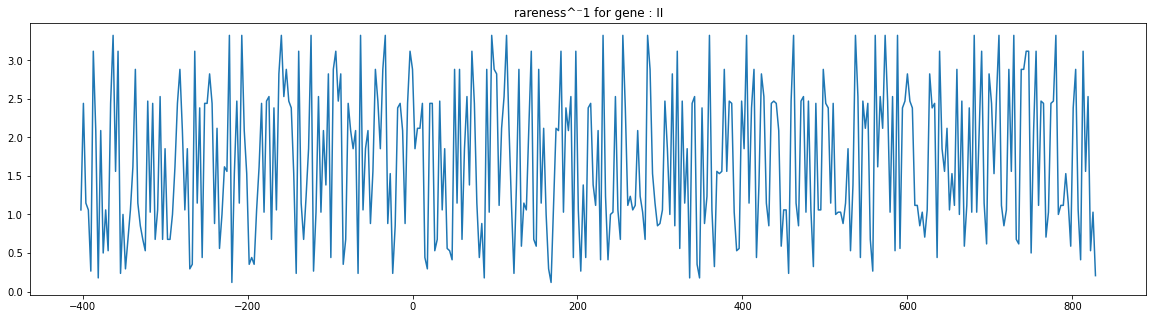

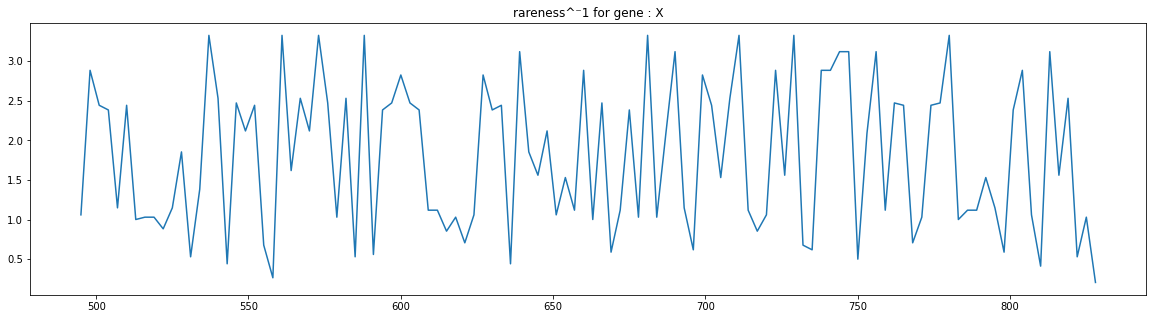

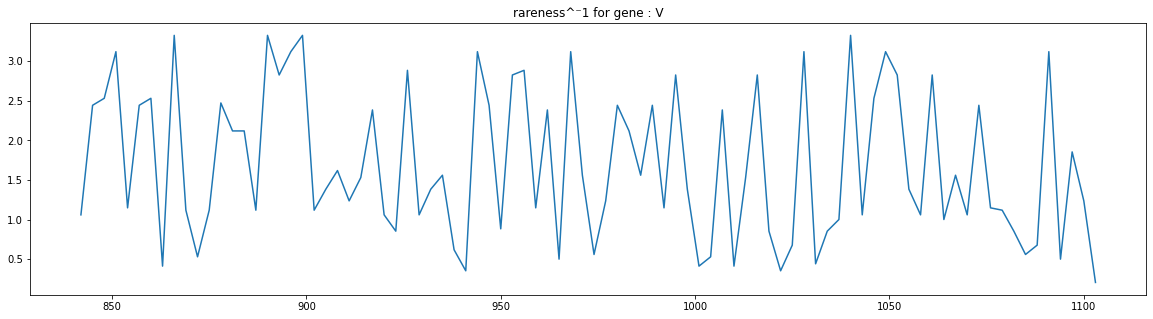

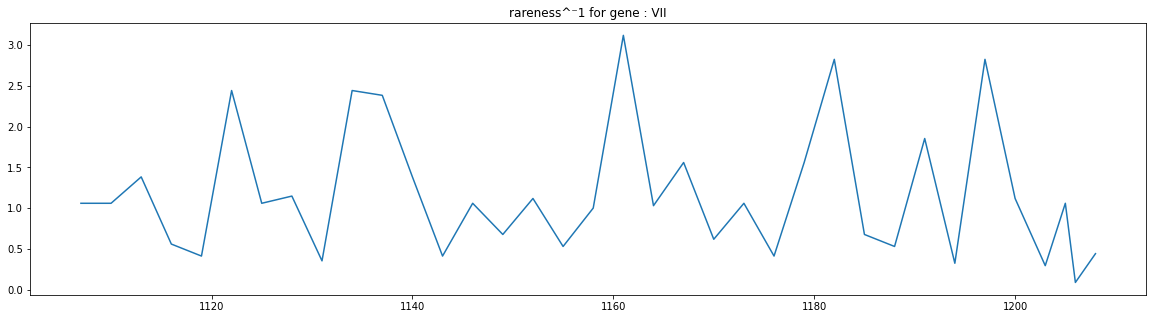

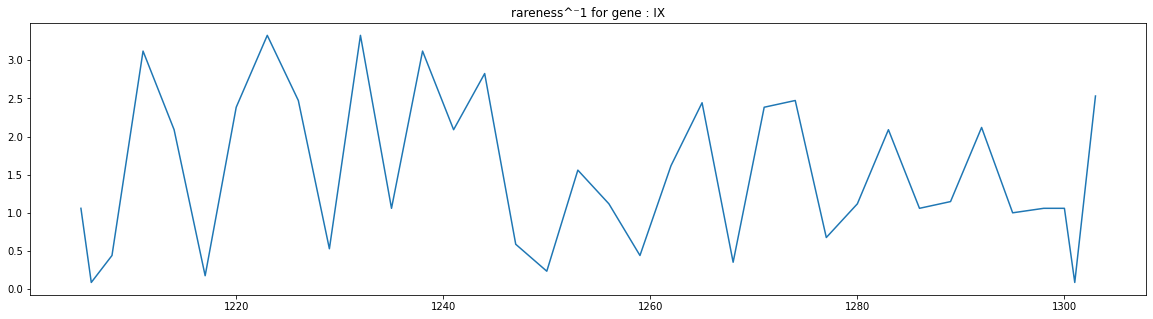

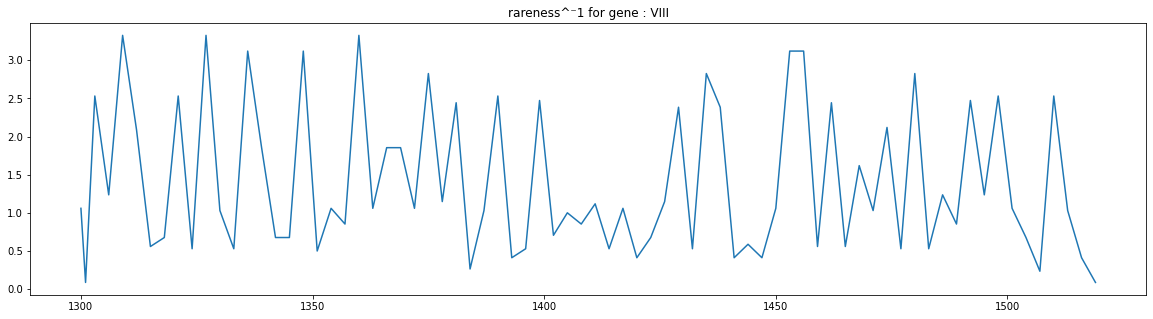

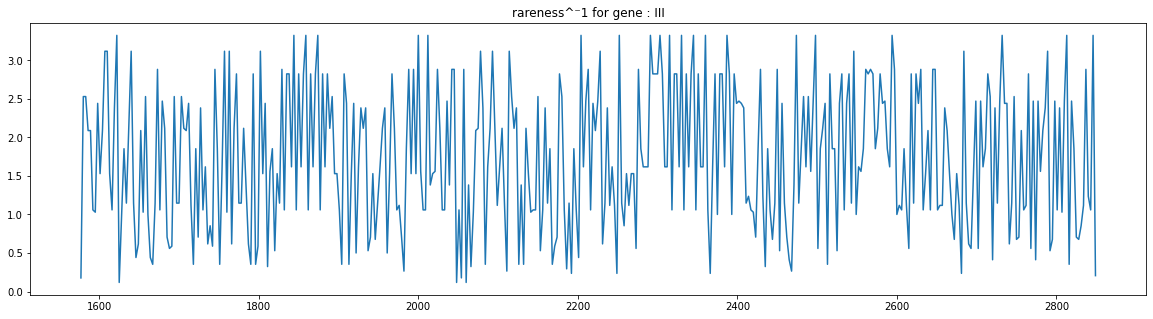

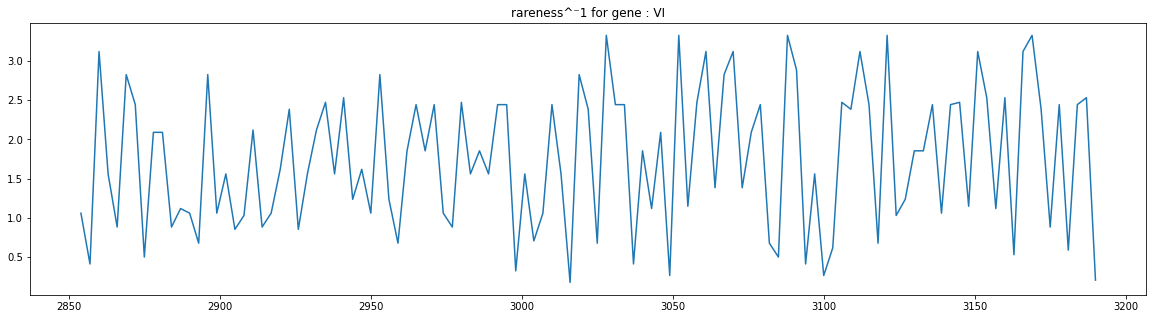

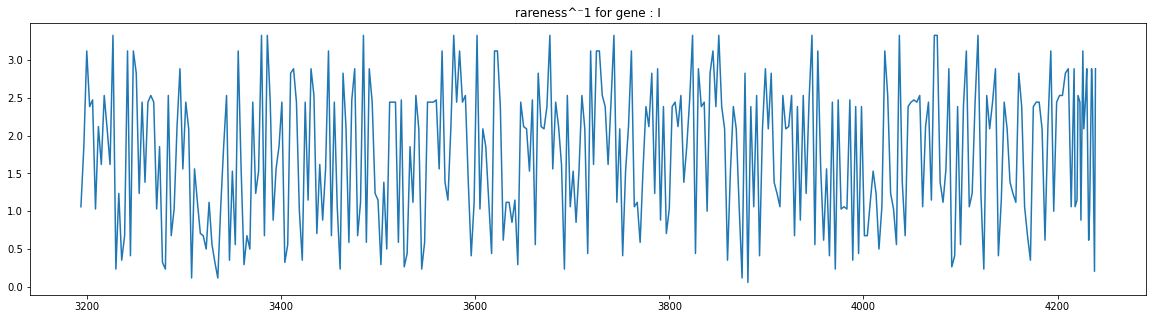

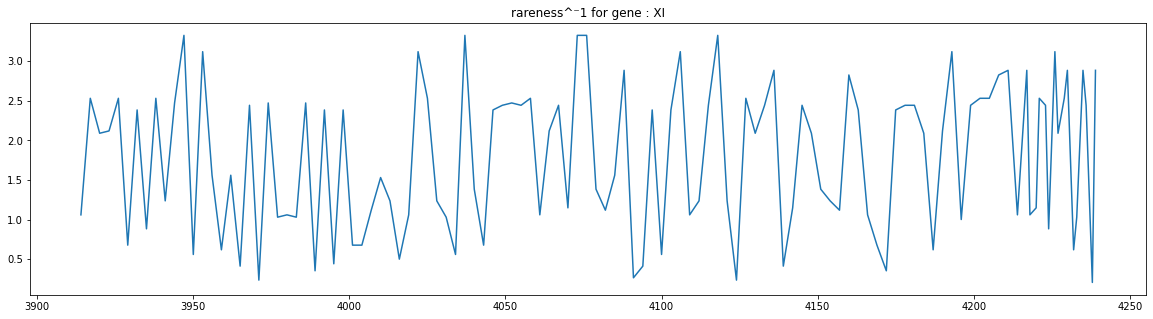

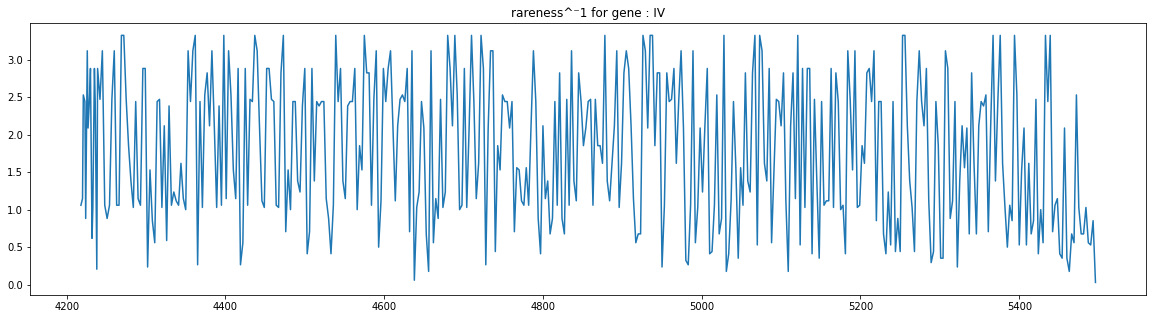

{-402: 1.0593103448275862, -399: 2.4422988505747125, -396: 1.1475862068965517, -393: 1.0593103448275862, -390: 0.26482758620689656, -387: 3.1190804597701147, -384: 2.0891954022988504, -381: 0.17655172413793102, -378: 2.0891954022988504, -375: 0.5002298850574712, -372: 1.0593103448275862, -369: 0.5296551724137931, -366: 2.4422988505747125, -363: 3.3250574712643677, -360: 1.5595402298850574, -357: 3.1190804597701147, -354: 0.2354022988505747, -351: 1.0004597701149425, -348: 0.2942528735632184, -345: 0.6767816091954023, -342: 1.0593103448275862, -339: 1.6183908045977011, -336: 2.88367816091954, -333: 1.1475862068965517, -330: 0.8533333333333334, -327: 0.6767816091954023, -324: 0.5296551724137931, -321: 2.4717241379310346, -318: 1.0298850574712644, -315: 2.4422988505747125, -312: 0.6767816091954023, -309: 1.0593103448275862, -306: 2.530574712643678, -303: 0.6767816091954023, -300: 1.853793103448276, -297: 0.6767816091954023, -294: 0.6767816091954023, -291: 1.0004597701149425, -288: 1.61839

In [11]:
#after some discussions with sebastien, we came to the conclusion we must check some littles things  before going foward with the initial plan of recoding. 
#1) make a graph of rare codons usage through the m13 genome (gene per gene): first, using the overall m13 genome as reference:
nb_of_aa = sum(infos_aa["count"] for infos_aa in codon_table_m13_kevun.values())   #total number of codons encoding aa in m13 genome
nb_of_codon = len(codon_table_m13_kevun)
excepted_occ_of_aa = nb_of_aa/nb_of_codon   #e_value

for codon, info in codon_table_m13_kevun.items():
    info["rareness_minus_one"] =  info["count"]/excepted_occ_of_aa
    
pos_rarescore = {}
for coor,cds in locations_in_kevin_m13.items():
    for idx in range(int(len(cds)/3)):
        codon = cds[idx*3:idx*3+3]
        pos_rarescore[coor[0]+idx*3] = codon_table_m13_kevun[codon]["rareness_minus_one"]

score_allpos_allgene = {}
for coor, genename in coor_genename.items():
    if genename not in score_allpos_allgene:
        score_allpos_allgene[genename] = {}
    for pos, rarescore in pos_rarescore.items():
        if pos >= coor[0] and pos <= coor[1]:
            if genename == "II" and pos > 7000:
                score_allpos_allgene[genename][pos-7927] = rarescore
            else:
                score_allpos_allgene[genename][pos] = rarescore

                

for genename, pos_score in score_allpos_allgene.items():     
    if genename != "II":
        plt.rcParams["figure.figsize"] = (20,5)
        lists = sorted(pos_score.items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.title("rareness^⁻1 for gene : "+str(genename))
        plt.plot(x, y)
        plt.show()  
    else:
        plt.rcParams["figure.figsize"] = (20,5)
        lists = sorted(pos_score.items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.title("rareness^⁻1 for gene : "+str(genename))
        plt.plot(x, y)
        plt.show()

print(score_allpos_allgene["II"])    


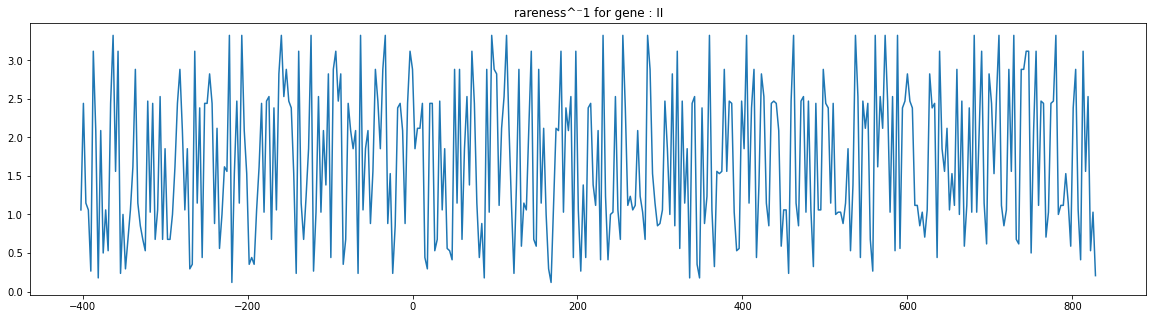

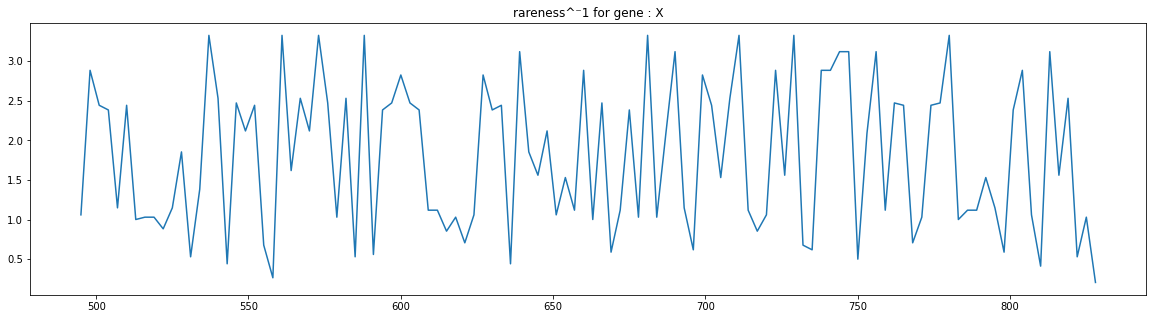

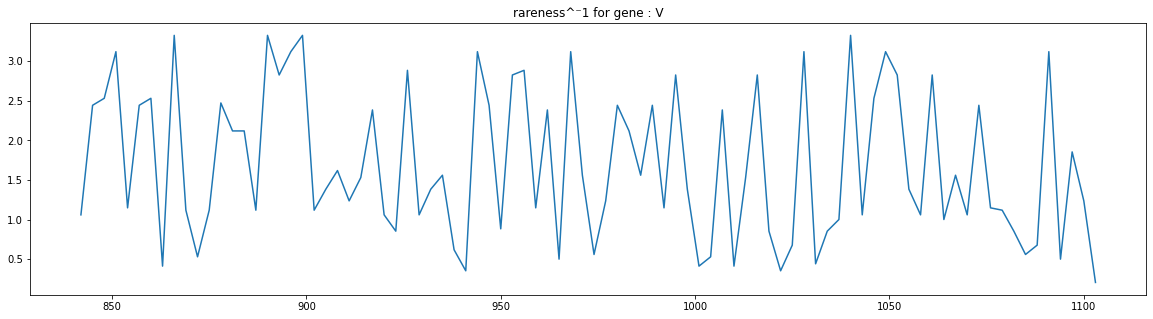

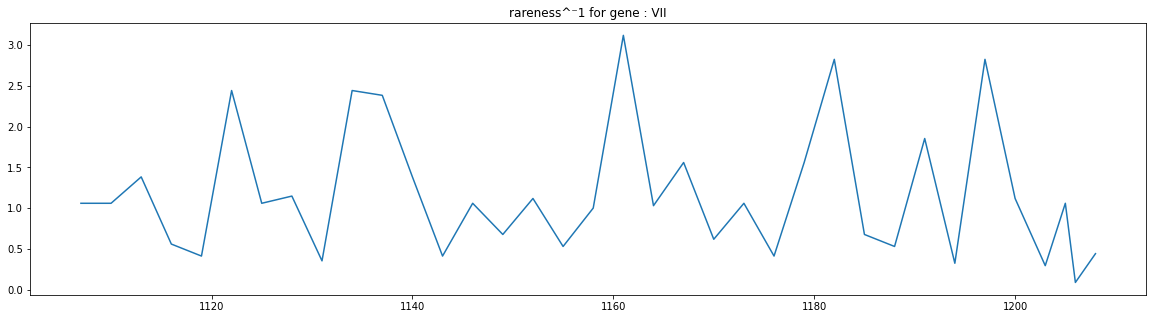

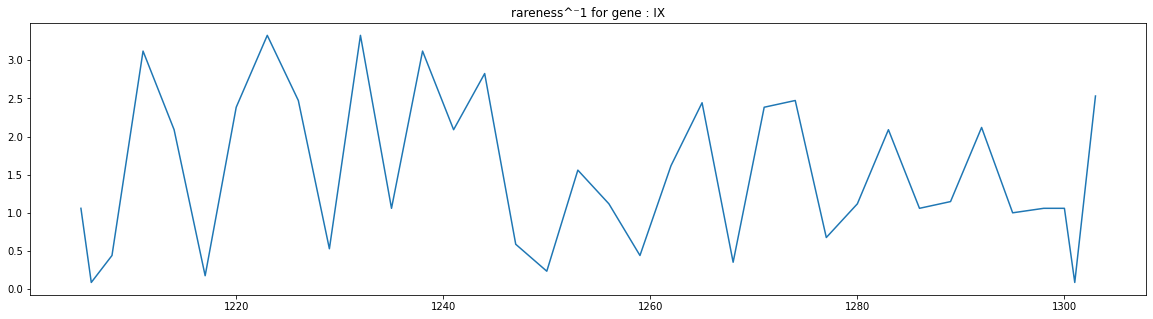

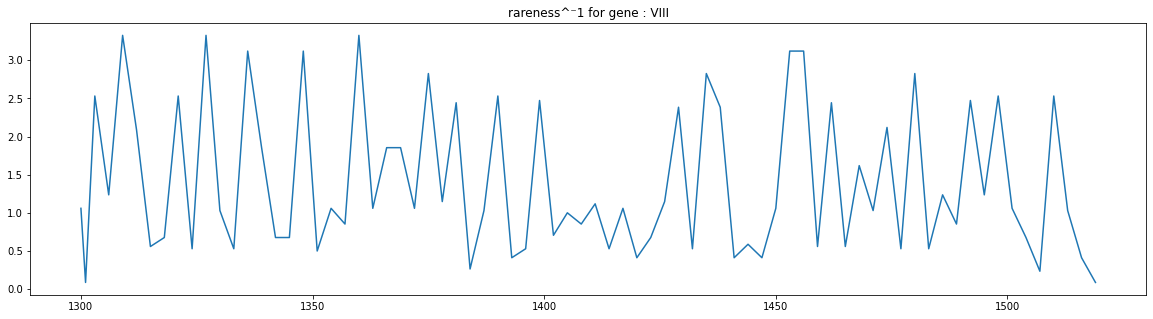

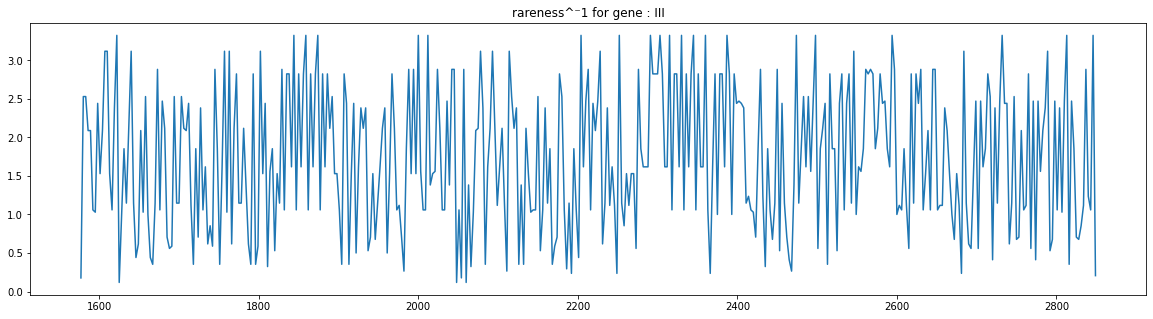

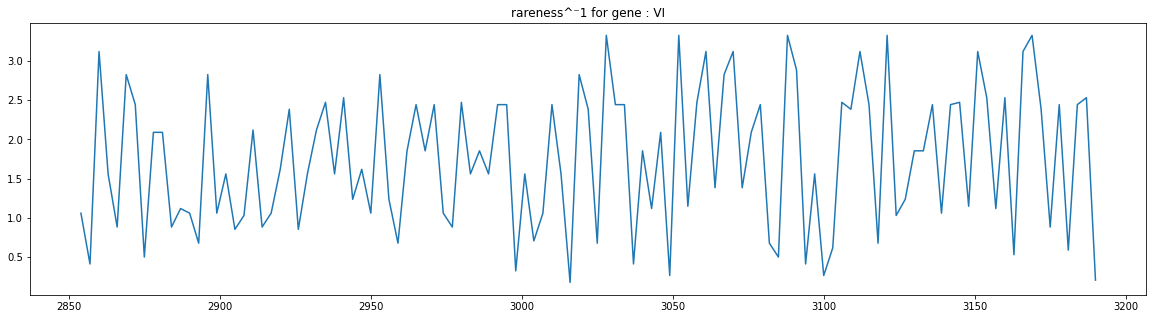

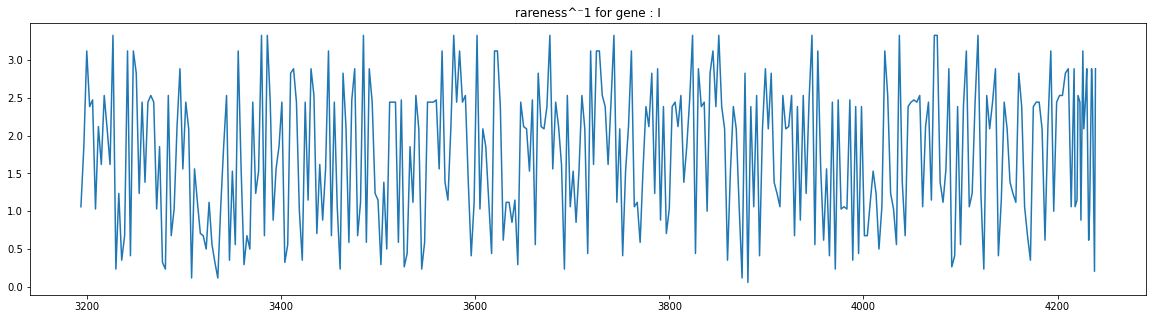

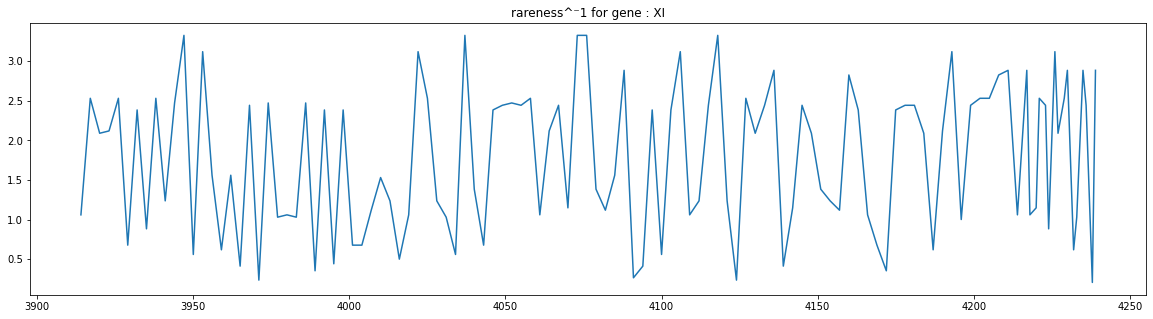

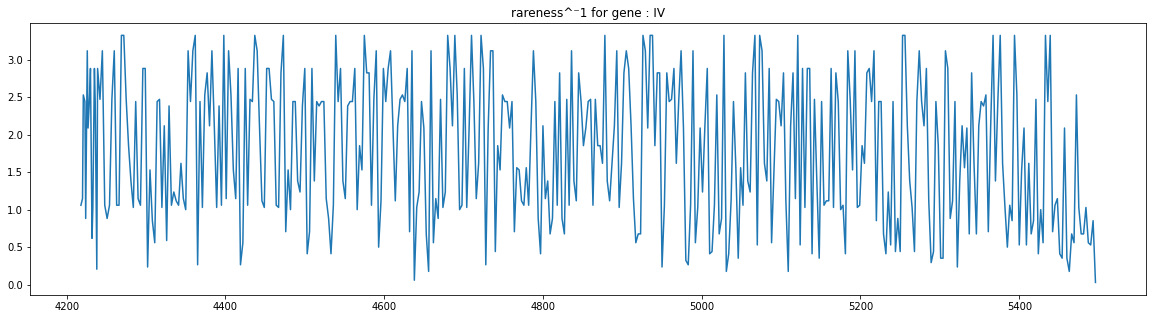

{-402: 1.0593103448275862, -399: 2.4422988505747125, -396: 1.1475862068965517, -393: 1.0593103448275862, -390: 0.26482758620689656, -387: 3.1190804597701147, -384: 2.0891954022988504, -381: 0.17655172413793102, -378: 2.0891954022988504, -375: 0.5002298850574712, -372: 1.0593103448275862, -369: 0.5296551724137931, -366: 2.4422988505747125, -363: 3.3250574712643677, -360: 1.5595402298850574, -357: 3.1190804597701147, -354: 0.2354022988505747, -351: 1.0004597701149425, -348: 0.2942528735632184, -345: 0.6767816091954023, -342: 1.0593103448275862, -339: 1.6183908045977011, -336: 2.88367816091954, -333: 1.1475862068965517, -330: 0.8533333333333334, -327: 0.6767816091954023, -324: 0.5296551724137931, -321: 2.4717241379310346, -318: 1.0298850574712644, -315: 2.4422988505747125, -312: 0.6767816091954023, -309: 1.0593103448275862, -306: 2.530574712643678, -303: 0.6767816091954023, -300: 1.853793103448276, -297: 0.6767816091954023, -294: 0.6767816091954023, -291: 1.0004597701149425, -288: 1.61839

In [245]:
#after some discussions with sebastien, we came to the conclusion we must check some littles things  before going foward with the initial plan of recoding. 
#1) make a graph of rare codons usage through the m13 genome (gene per gene): second, using the rarety comparing with e.coli genome:
nb_of_aa = sum(infos_aa["count"] for infos_aa in codon_table_m13_kevun.values())   #total number of codons encoding aa in m13 genome
nb_of_codon = len(codon_table_m13)
excepted_occ_of_aa = nb_of_aa/nb_of_codon   #e_value

for codon, info in codon_table_ecoli.items():
    info["rareness_minus_one"] =  info["count"]/excepted_occ_of_aa
    
pos_rarescore = {}
for coor,cds in locations_in_kevin_m13.items():
    for idx in range(int(len(cds)/3)):
        codon = cds[idx*3:idx*3+3]
        pos_rarescore[coor[0]+idx*3] = codon_table_m13_kevun[codon]["rareness_minus_one"]

score_allpos_allgene = {}
for coor, genename in coor_genename.items():
    if genename not in score_allpos_allgene:
        score_allpos_allgene[genename] = {}
    for pos, rarescore in pos_rarescore.items():
        if pos >= coor[0] and pos <= coor[1]:
            if genename == "II" and pos > 7000:
                score_allpos_allgene[genename][pos-7927] = rarescore
            else:
                score_allpos_allgene[genename][pos] = rarescore

for genename, pos_score in score_allpos_allgene.items():     
    if genename != "II":
        plt.rcParams["figure.figsize"] = (20,5)
        lists = sorted(pos_score.items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.title("rareness^⁻1 for gene : "+str(genename))
        plt.plot(x, y)
        plt.show()  
    else:
        plt.rcParams["figure.figsize"] = (20,5)
        lists = sorted(pos_score.items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.title("rareness^⁻1 for gene : "+str(genename))
        plt.plot(x, y)
        plt.show()

print(score_allpos_allgene["II"])    


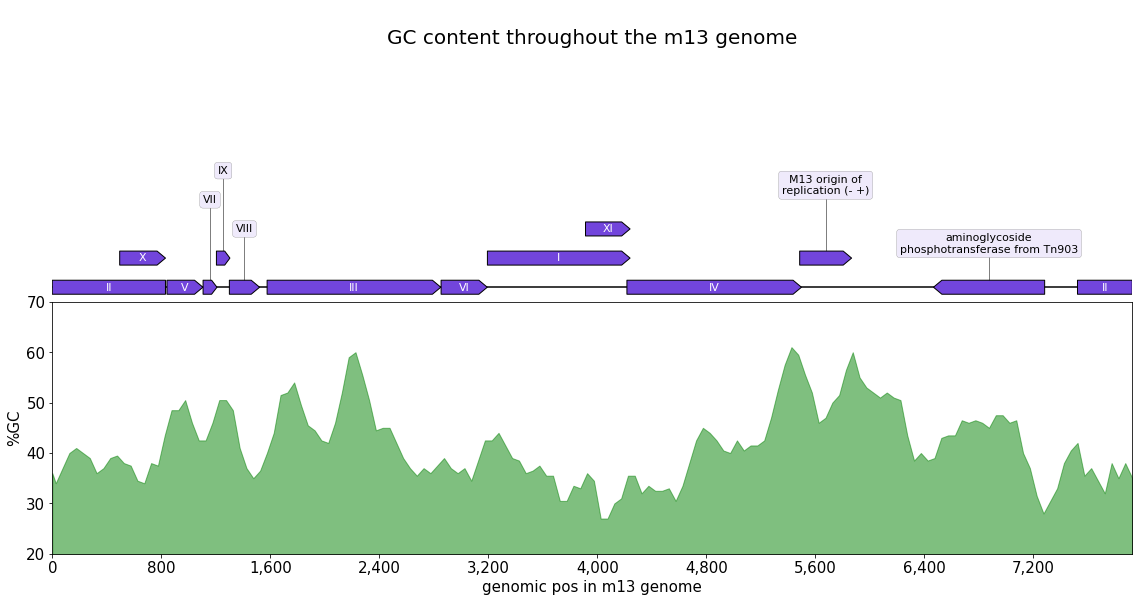

In [216]:
#gc content for genome wide and gene by gene:
#np.asarray(someListOfLists, dtype=np.float32)
import matplotlib.cm as cm
def plot_GC_content(filename,bin_len,step):
    #filename: the specific place where the file is. Must be a genbank file. (or even ape).
    #bin_len: len of bin. getting the mean of GC content in that bin.Should not be 0 !
    #step: step between the bin. The larger the step, the softer the curve (less spikes). Should not be 0.
    #i recommand step < bin_len
    assert bin_len%2==0 , "his values has to be %2 == 0"
    fig, (ax1,ax2) = plt.subplots(
        2, 1, figsize=(15, 7), sharex=True, gridspec_kw={"height_ratios": [10, 10]},
    )
    # PLOT THE RECORD MAP
    record = SeqIO.read(filename, "genbank")
    for feat in record.features:
        if feat.type == "CDS":
            record.features.remove(feat)
        elif "join" in str(feat.location):
            record.features.remove(feat)
            for i in str(feat.location).split(","):
                coor = []
                for j in i.split(":"):
                    j_corrected = re.sub("[^0-9]","",j)
                    coor.append(j_corrected)
                record.features.append(SeqFeature(FeatureLocation(int(coor[0]), int(coor[1])), type=feat.qualifiers["gene"][0],))
        try:
            if "a" in str(feat.qualifiers["gene"][0]):
                record.features.remove(feat)
        except:
            continue
    while len([feat for feat in record.features if "CDS" == feat.type]) != 1:        
        for feat in record.features:
            if "CDS" == feat.type:
                if "Tn903" in str(feat.qualifiers["gene"][0]):
                    continue
                record.features.remove(feat)
    for feat in record.features:
        try:
            if "a" in str(feat.qualifiers["gene"][0]):
                if "Tn903" in str(feat.qualifiers["gene"][0]):
                    continue
                record.features.remove(feat)
        except:
            continue
 
    graphic_record = BiopythonTranslator().translate_record(record)
    graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=4)
    
    #xx is the position at which we would like to have a GC content value. list like object.  
    xx = np.arange(0,len(record.seq)-bin_len,step).tolist()
                    
    #need to modify the axis for plotting gc content in the middle of a bin.
    xaxis = []
    lg_dna=int(len(record.seq))
    for x in xx:
        if x != xx[-1]:
            xaxis.append((x+step+x)/2)
        else:
            xaxis.append((x+step+x)/2)
            for n in range(x+step,lg_dna,step):
                if n < lg_dna-step:
                    xaxis.append((n+step+n)/2)
                    xx.append(n)
                else:
                    xaxis.append(lg_dna)
                    xx.append(n)
            break
    xaxis.insert(0, 0) 
    xx.append(0)
    yy = []
        #yy compute GC% on each bin on length 'bin_len'. The last coor has its own custom bin (and others if x > lg_dna-bin_len), such as 0 coor (with a similar bin content than the last one)
    for j,x in enumerate(xx):
        if x == 0 and j > 1:
            yy.append((GC(record.seq[int(lg_dna-bin_len/2):lg_dna])+GC(record.seq[:int(bin_len/2)]))/2)
            continue
        if x < lg_dna-bin_len:
            yy.append(GC(record.seq[x:x+bin_len]))

        else:
            pond1 = (lg_dna-x)/bin_len
            pond2 = (bin_len-(lg_dna-x))/bin_len
            yy.append(pond1*GC(record.seq[x:lg_dna])+pond2*GC(record.seq[:bin_len-(lg_dna-x)]))
    ax2.fill_between(xaxis, yy, alpha=0.5,color="g") #alpha for % of opacity (transparency^-1)
    ax2.set_ylim(bottom=0)
    
    extent = [0, max(xaxis) , 0,1] #coordinates for the secondary axis S
    # choose a color present in https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    #yy=np.asarray(yy)
    #ax1.imshow(yy[np.newaxis,:], cmap="inferno", aspect="auto", extent=extent)
    #ax1.set_yticks([])
    ax1.set_xlim(extent[0], extent[1])
    ax2.set_ylim(20,70)
    ax2.set_ylabel("%GC", fontsize = 15)
    ax2.set_xlabel("genomic pos in m13 genome", fontsize = 15)
    ax1.set_visible(True)
    ax1.set_title("\n"+'GC content throughout the m13 genome', fontsize = 20)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=15)
    fig.set_facecolor("w")
    plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=1, 
                    wspace=0, 
                    hspace=0)
    plt.show()
    
#     return xaxis, yy
plot_GC_content("../ref_files_m13/m13mp18-Kan.ape",200,50)


AttributeError: 'list' object has no attribute 'min'

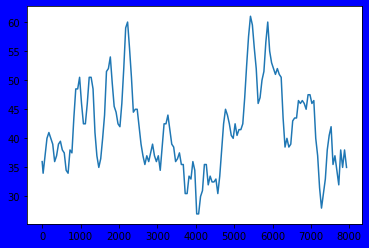

In [72]:
#TOMORROW, GO SEE GC CONTENT OR SPECFIC GENE!
def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    import matplotlib.colors as mcolors
    from matplotlib.patches import Polygon
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

gradient_fill(xaxis,yy)

In [28]:
for i in range(0,255,25):
    print(i)

0
25
50
75
100
125
150
175
200
225
250


In [106]:
print(GC("AATGCTACTACTATTAGTAGAAT"))

26.08695652173913


In [110]:
print(GC("AATGCTACTACTATTAGTAGAATTGATGCCACCTTTTCAGCTCGCGCCCCAAATGAAAATATAGCTAAACAGGTTATTGACCATTTGCGAAATGTATCTAATGGTCAAACTAAATCTACTCGTTCGCAGAATTGGGAATCAACTGTTATATGGAATGAAACTTCCAGACACCGTACTTTAGTTGCATATTTAAAACATGT"))

36.0


In [138]:
for n in range(7700,7927,50):
    print(n)

7700
7750
7800
7850
7900
